# Structure of the T cell Receptor Repertoire in IBD-Pilot Data

This dataset is a pilot dataset of T cell receptor (beta-chain) data from patients with inflammatory bowel disease (Crohn's disease, ulcerative colitis, and healthy controls). The samples are both peripheral blood samples, and colonic biopsy samples from inflamed and normal sites.

The data was generated by AbVitro using methods similar to [this paper](https://www.ncbi.nlm.nih.gov/pubmed/24793455). The main takeaways are that each mRNA molecule in the original sample is labeled with a unimolecular barcode, allowing for correction of PCR errors and bias.

Data are from 6 patients, 2 Crohn's, 2 UC, and 2 healthy controls. There is also an accompanying dataset of B cell receptors.

## Primary Questions
1. What is the overlap between blood samples and biopsy samples?
2. Does that overlap appear to change in patients with inflammatory bowel disease (n limited)?
3. Does focusing on more frequent TCRs improve statistical power or reveal obscured patterns?
4. Do TCRs in this pilot follow lognormal distributions?

A useful paper that discusses the analysis of B cell receptor data is [here](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-015-0243-2).

### Definitions:
TCR mRNA: a unique mRNA sequence identified by the TCR-seq method, encoding the V, J, and CDR3 sequences.

TCR clonotype: a unique combination of V, J, and CDR3 nucleotide sequence. Thought to be dervied from a common ancestor.

TCR epitope: a unique combination of V, J, and CDR3 amino acid sequence. Represents the same TCR as experienced/presented to antigens.

Effectively however, these 3 different ways of defining a TCR are all very similar, since each TCR mRNA most likely offers a unique TCR clonotype and epitope

Convergent evolution: thymic or other selection favors the same TCRs across different individuals.

Convergent recombination: multiple nucleotide sequences (like TCR clonotypes) encode the same amino acid sequence (TCR epitope).

In [66]:
import matplotlib.pyplot as plt, matplotlib_venn as plt_venn, warnings
import pandas as pd, numpy as np, seaborn as sns, skbio.diversity as div
from collections import Counter, defaultdict, OrderedDict
from math import exp
from skbio.stats import subsample_counts
from itertools import combinations, count, chain
from scipy.stats import norm, kstest, spearmanr
from ete3 import Tree
from scipy.stats import fisher_exact
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
def plot_ind_freq(frequency_list, log=False, descending=True):
  """
  For a given list of frequencies, plots each frequency in order. This script
  helps visualize the decay of frequencies of things like TCRs
  """
  if descending:
    frequency_list = sorted(frequency_list, reverse=True)
  else:
    frequency_list = sorted(frequency_list)
  x_val = range(len(frequency_list))
  plt.scatter(x_val, frequency_list, facecolors='none', edgecolors='grey')
  if log:
    plt.yscale('log')

In [3]:
def df_pw_heatmap(df, groupby_col, function, **kwargs):
    """
    With an input dataframe, splits the dataframe by the groupby_col entry. For
    each pair of these resulting subtables, calculates a single output (such as
    a distance) using the variable function.
    
    Return an array of these pairwise values
    
    function must be a function that accepts two pandas dataframes as input
    """
    groups = df[groupby_col].unique()
    results_table = pd.DataFrame(index=groups, columns=groups) #final table
    for i, j in combinations(groups, 2):
        i_tab = df.loc[df[groupby_col] == i]
        j_tab = df.loc[df[groupby_col] == j]
        pw_result = function(i_tab, j_tab, **kwargs)
        results_table.set_value(i, j, pw_result)
        results_table.set_value(j, i, pw_result)
    return results_table

In [4]:
def overlap_num(df1, df2, set_column):
    """
    Returns the overlaps between sets from df1 and df2 in the column set_column
    """
    return len(set(df1[set_column]) & set(df2[set_column]))

In [5]:
def jaccard_df(df1, df2, set_column):
    """
    Calculates the jaccard similarity between two dataframes, using the column
    set_column
    """
    x = set(df1[set_column])
    y = set(df2[set_column])
    return len(x & y)/len(x | y)

In [6]:
def jensen_shannon(x, y):
    """
    calculates the jensen-shannon divergence between two vectors: x and y
    @author: jonathanfriedman
    Accept lists, series
    """
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    x, y = np.array(x), np.array(y)
    dist_1 = x * np.log2(2 * x/(x + y))
    dist_2 = y * np.log2(2 * y/(x + y))
    dist_1[np.isnan(dist_1)] = 0
    dist_2[np.isnan(dist_2)] = 0
    dist_final = 0.5 * np.sum(dist_1 + dist_2)    
    return dist_final

In [7]:
def jsd_df(df1, df2, set_column_label, set_column_freq):
    """
    Calculates the Jensen-shannon distance between two dataframes. set_column_freq
    is the column label of the frequencies to be compared and set_column_label
    indicates the corresponding matching labels for each frequency value
    """
    x = df1.set_index(set_column_label)
    x = x[set_column_freq].rename('x')
    y = df2.set_index(set_column_label)
    y = y[set_column_freq].rename('y')
    tmp = pd.concat([x, y], axis=1)
    return jensen_shannon(tmp['x'], tmp['y'])

In [8]:
def shr_jsd_df(df1, df2, set_column_label, set_column_freq):
    """
    Calculates the shared jensen-shannon distance between two dataframes. 
    Shared means elements common to both dataframes. The elements considered
    are names in the column set_column_label, while the frequency of those
    elements are in the column set_column_freq
    """
    shared = set(df1[set_column_label]) & set(df2[set_column_label])
    x = df1[[set_column_label, set_column_freq]].loc[df1[set_column_label].isin(shared)]
    x = x.set_index(set_column_label)
    x = x[set_column_freq].rename('x')
    y = df2[[set_column_label, set_column_freq]].loc[df2[set_column_label].isin(shared)]
    y = y.set_index(set_column_label)
    y = y[set_column_freq].rename('y')
    tmp = pd.concat([x, y], axis=1)
    return jensen_shannon(tmp['x'], tmp['y'])

In [9]:
def plot_freq_comparison(x_series, y_series, log=True, spearman=True):
    """
    Takes two series, which are assumed to be the same type of values and 
    plot the two against each other.
    
    The two series either must have identical indexes OR have indexes that
    are related, and thus comparison of each index is valid
    
    Log will plot both axes using a log scale
    Spearman will annotate the figure with the # of shared elements, spearman rho, and p val
    Return axes will return the axes object
    """
    tmp_table = pd.concat([x_series, y_series], axis=1)
    tmp_table = tmp_table.fillna(0) #fill missing values with zero
    plt.scatter(tmp_table.iloc[:, 0].values, tmp_table.iloc[:, 1].values,
                facecolors='none', edgecolors='grey')
    plot_max = max([x_series.max(), y_series.max()])
    linthresh = min([x_series.min(), y_series.min()])
    if log:
        plt.xscale('symlog', linthreshx=linthresh)
        plt.yscale('symlog', linthreshy=linthresh)
    plt.xlim(0, plot_max)
    plt.ylim(0, plot_max)
    sns.despine()
    
    #calculate spearman correlation and report
    if spearman:
        tmp_table = tmp_table[~(tmp_table == 0).any(axis=1)] #keep only shared tcrs
        rho, pval = spearmanr(tmp_table.iloc[:, 0].values, 
                              tmp_table.iloc[:, 1].values)
        plt.annotate('shared elements = {0}, rs = {1:.5f}, p = {2:.5f}'.format(len(tmp_table.index), rho, pval), 
                     xy=(1,0.05), xycoords='axes fraction', 
                     horizontalalignment='right', verticalalignment='bottom')

In [10]:
def brackets_to_colon(newick_file, output=False):
    """
    branch support (like bootstrap values) are sometimes marked as bracketed
    values (like in iTOL):
    
    (denovo1713:0.01345,denovo253:0.01375):0.08982[0.899],denovo . . .
    
    In other cases, they are indicated by an additional colon field (like in 
    ETE3):
    
    (denovo1713:0.01345,denovo253:0.01375)0.899:0.08982,denovo . . .
    
    This function goes from the bracket format to the colon format
    """
    with open(newick_file, 'r') as newick:
        newick_str = newick.readline()
        
    final_list = []
    iter_newick = enumerate(newick_str)
    for idx, char in iter_newick:
        if char == '[':
            branch_label_list = []
            while True:
                idx1, char1 = next(iter_newick)
                if char1 == ']':
                    break
                branch_label_list.append(char1)
            branch_label = ''.join(branch_label_list)
            final_list.insert(len(final_list) - final_list[::-1].index(")"),
                              branch_label)
        else:
            final_list.append(char)
    if output:
        with open(output, 'w') as output_file:
            output_file.write(''.join(final_list))
    return ''.join(final_list)

In [11]:
def greedy_cluster(elements, dist_func, dist_cutoff, less=True, **kwargs):
    """
    This script performs a greedy clustering algorithm on the list 'elements'. It will look at
    each element sequentially as it is presented in 'elements', so if this list is sorted by
    descending frequency, it will consider the most frequent elements first. For each element,
    it will calculate the distance between that element and all other cluter representatives
    using the function dist_func. If the numeric output of dist_func is less than the 
    dist_cutoff, then it will merge that element into that cluster. Otherwise, it will make a
    new cluters with that element as the representative.
  
    Similar strategy to USEARCH for OTU calling. **kwargs will be passed to dist_func.
    'elements' should not contain repeats. If less=True, then the output of dist_func must
    be less than dist_cutoff to cluster two elements. Otherwise greater than
    """
    cluster_dict = OrderedDict() #use an ordered dictionary to maintain order of insertion
    for element in elements:
        match = False
        for rep in cluster_dict.keys():
            if less:
                if dist_func(element, rep, **kwargs) < dist_cutoff:
                    cluster_dict[rep].append(element)
                    match = True
                    break
            else:
                if dist_func(element, rep, **kwargs) > dist_cutoff:
                    cluster_dict[rep].append(element)
                    match = True
                    break
        if not match:
            cluster_dict[element] = [element]
    return cluster_dict

In [12]:
def tree_dist(leaf1, leaf2, ete_tree):
    return ete_tree.get_distance(leaf1, leaf2)

In [13]:
def series_to_fasta(series, output_file, labels=False):
    """
    Write a series to a fasta file (output)
    If labels is provided, use them as the sequence names
    Otherwise, just labels them as seq#
    """
    with open(output_file, 'w+') as output:
        if labels:
            for label, seq in zip(labels, series):
                if seq == None:
                    continue
                output.write('>' + label + '\n' + seq + '\n')
        else:
            counter = 0
            for seq in series:
                if seq == None:
                    continue
                output.write('>seq' + str(counter) + '\n' + seq + '\n')
                counter += 1

In [14]:
def count_kmers(seq_iter, k, count_occurence=False):
    """
    This script will count the incidences of each amino acid (or character)
    motif of length k (kmer) in the sequences of seq_iter.
    
    The primary output will be a dictionary, with an entry for each kmer and a
    count of the number of sequences in which that kmer occured.
    
    If count_occurence == True, then simply report the total number of 
    occurences of each kmer, including when multiple kmers are found in one 
    sequence. If False, then returns the number of sequences in seq_iter that
    contained each kmer
    """
    kmer_dict = defaultdict(int)
    for seq in seq_iter:
        kmers = [seq[i: i + k] for i in range(len(seq) - k + 1)]
        if count_occurence:
            for kmer in kmers:
                kmer_dict[kmer] += 1
        else:
            for kmer in set(kmers):
                kmer_dict[kmer] += 1
    return kmer_dict

In [15]:
def differential_kmers(seq_iter1, seq_iter2, k, max_pval=0.05):
    """
    Using a Fisher's exact test, outputs a pandas table of kmers that are
    significantly differentially abundant between two lists of sequences.
    
    The resulting table gives the kmer sequence, the number of counts in 
    seq_iter1, the number of counts in seq_iter2, the logfold change in 
    frequency from seq_iter1 to seq_iter2 (i.e., log fold change of 1
    means that the frequency of the kmer in seq_iter2 is twice that of the
    frequency in seq_iter1, the fisher-exact odds ratio,the p value, and 
    the bonferroni-corrected p value.
    
    No multiple hypothesis correction is performed.
    
    Max_pval sets the maximum kmer p value to be reported in the table. Set
    as False if the full dataset is desired.
    """
    kmers1 = count_kmers(seq_iter1, k)
    kmers2 = count_kmers(seq_iter2, k)
    
    cols = ['kmer_seq', 'count_1', 'count_2', 'freq_1', 'freq_2', 'lg_chg', 
            'fe_odds', 'p_val']
    kmer_tab = pd.DataFrame(columns=cols) #final result table
    
    all_kmers = set(list(kmers1.keys()) + list(kmers2.keys()))
    kmer1_tot = sum(kmers1.values())
    kmer2_tot = sum(kmers2.values())
    print('total kmers in the first iterable is ' + str(kmer1_tot))
    print('total kmers in the second iterable is ' + str(kmer2_tot))
    for kmer in all_kmers:
        count1 = kmers1[kmer]
        count2 = kmers2[kmer]
        odds, p = fisher_exact([[count1, kmer1_tot - count1], 
                                [count2, kmer2_tot - count2]])
        tmp_srs = pd.Series([kmer, count1, count2, count1/kmer1_tot, 
                             count2/kmer2_tot,
                             np.log2(count2/kmer2_tot) - np.log2(count1/kmer1_tot),
                             odds, p], index=cols)
        kmer_tab = kmer_tab.append(tmp_srs, ignore_index=True)
    
    if max_pval: #remove rows with to great of a p_val
        kmer_tab = kmer_tab.loc[kmer_tab['p_val'] <= max_pval]
    kmer_tab['bf_p_val'] = kmer_tab['p_val'] * len(all_kmers)
    kmer_tab.ix[kmer_tab['bf_p_val'] > 1, 'bf_p_val'] = 1 #cap p at 1
    kmer_tab['lg_bf_p_val'] = kmer_tab['bf_p_val'].apply(np.log)
    kmer_tab = kmer_tab.sort_values('p_val')
    return kmer_tab

In [16]:
ibd_tcr_raw_tab = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/ibd_tcr_pilot/tcrb_ibd_pilot_tidy_20170413.txt',
                         sep='\t')

In [17]:
#clean table, removing unproductive TCRs and where v or j is unresolved
ibd_tcr_tab = ibd_tcr_raw_tab.loc[ibd_tcr_raw_tab['prod'] == 'productive']
ibd_tcr_tab = ibd_tcr_tab.loc[-(ibd_tcr_tab['v'].str.contains(','))] #v unresolved
ibd_tcr_tab = ibd_tcr_tab.loc[-(ibd_tcr_tab['j'].str.contains(','))] #j unresolved

In [18]:
tmp = ibd_tcr_tab[['sample', 'patient', 'tissue', 'site', 'disease']]
sample_metadata = tmp.drop_duplicates().reset_index(drop=True).set_index('sample')

In [91]:
sample_metadata

,patient,tissue,site,disease
sample,,,,
7153B,7153,blood,blood,cd
7153IT,7153,biopsy,inflamed,cd
7153NT,7153,biopsy,normal,cd
7783B,7783,blood,blood,cd
7783IT,7783,biopsy,inflamed,cd
7783NT,7783,biopsy,normal,cd
8275B,8275,blood,blood,uc
8275IT,8275,biopsy,inflamed,uc
8505B,8505,blood,blood,uc


In [19]:
ibd_tcr_tab_sample_groupby = ibd_tcr_tab.groupby('sample')

In [47]:
ibd_tcr_tab.head()

,cdr3_nt,v,j,prod,sample,counts,patient,tissue,site,disease,cdr3_aa,freq,tcr_epitope,tcr_clonotype
0,gccagcttgactagagggggagcagaggagacccagtac,TRBV7-2*01,TRBJ2-5*01,productive,7153B,1,7153,blood,blood,cd,ASLTRGGAEETQY,0.00001,tcr_0,tcr_0
1,gccagcagcccgggtctagcgggccgctacgagcagtac,TRBV7-2*01,TRBJ2-7*01,productive,7153B,1,7153,blood,blood,cd,ASSPGLAGRYEQY,0.00001,tcr_1,tcr_1
2,gccagcagtttatcggggcgggaggcaccttcctacgagcagtac,TRBV27*01,TRBJ2-7*01,productive,7153B,1,7153,blood,blood,cd,ASSLSGREAPSYEQY,0.00001,tcr_2,tcr_2
4,agcgttgtaccgggaaacactgaagctttc,TRBV29-1*01,TRBJ1-1*01,productive,7153B,1,7153,blood,blood,cd,SVVPGNTEAF,0.00001,tcr_4,tcr_4
6,gccagcagcctgacgggactagcggttaatgagcagttc,TRBV9*01,TRBJ2-1*01,productive,7153B,1,7153,blood,blood,cd,ASSLTGLAVNEQF,0.00001,tcr_6,tcr_6


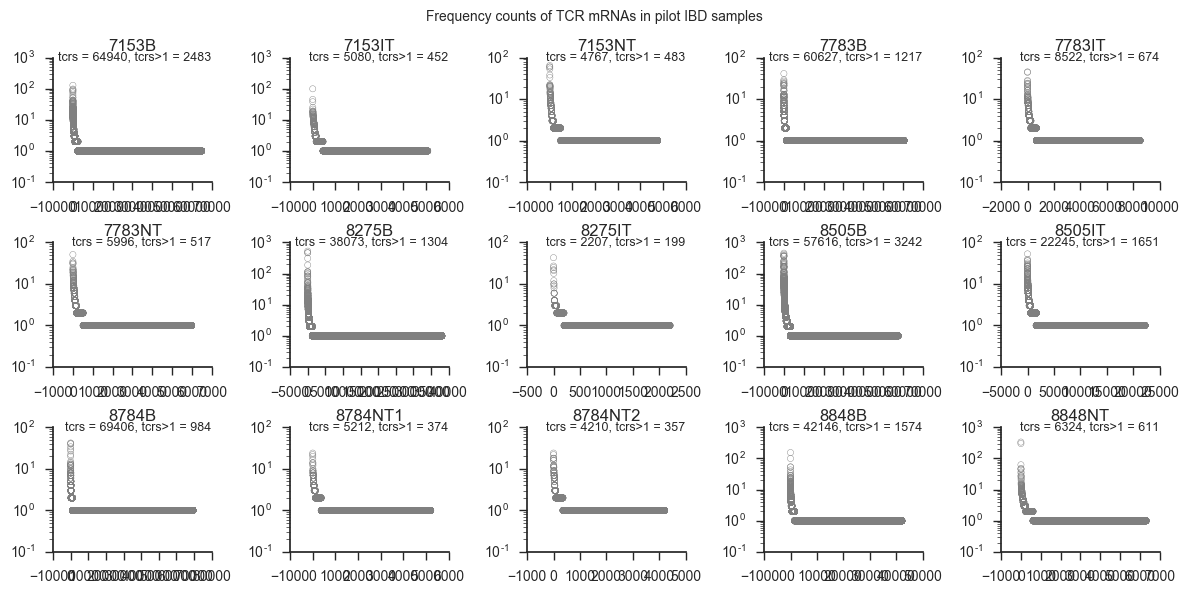

In [19]:
#Look at frequency decay of individual mRNA sequences. Multiple of these are in each 
#TCR clonotype, which may be primer/seq errors or actual different clones.

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCR mRNAs in pilot IBD samples")

counter = 1
for name, group in ibd_tcr_tab.groupby('sample'):
    ax = fig.add_subplot(3,5,counter)
    plot_ind_freq(group['counts'], log=True) #plot counts, not collapsing by tcr_clonotype
    plt.title(name)
    num_total = len(group)
    num_morethan_1 = sum(group['counts'] > 1)
    plt.annotate('tcrs = {0}, tcrs>1 = {1}'.format(num_total, num_morethan_1), 
                xy=(1,0.95), xycoords='axes fraction', 
                horizontalalignment='right', verticalalignment='bottom',
                fontsize=9)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Our count curves looks like they definitely don't saturate the TCR repertoire at the level of mRNAs, since all of them flatline at 1 count. Most samples have very few TCRs with more than a single count, usually in the single digit percentiles. Do these samples still appear to have a normal looking log-transformed values of TCR frequencies?

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


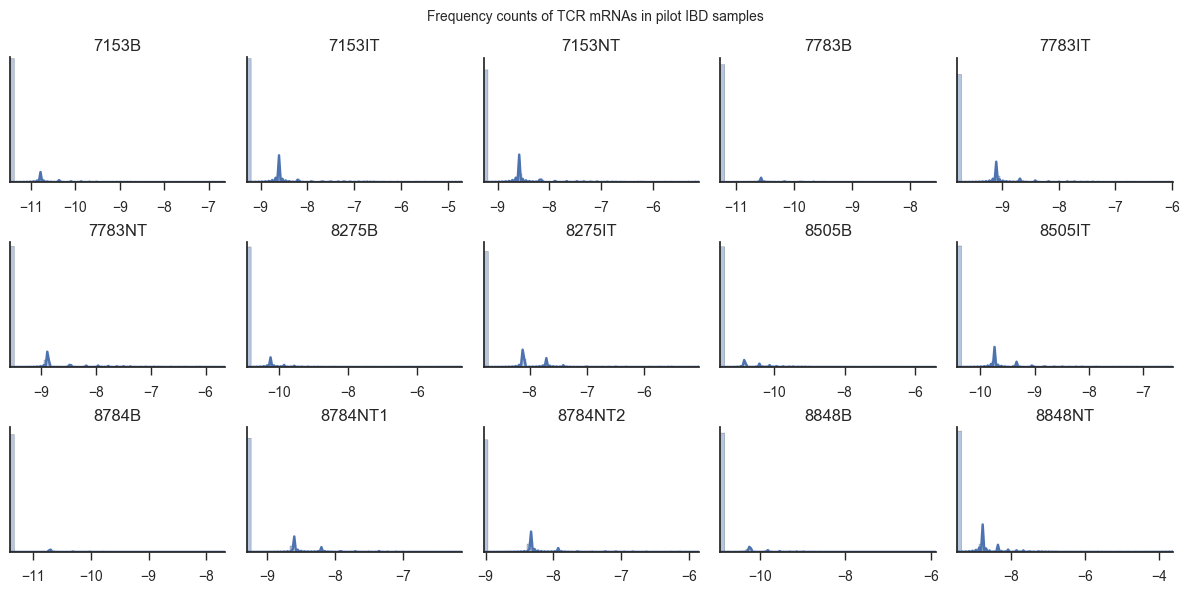

In [20]:
#Look at individual mRNA frequency distributions

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCR mRNAs in pilot IBD samples")

counter = 1
for name, group in ibd_tcr_tab.groupby('sample'):
    ax = fig.add_subplot(3,5,counter)
    sns.distplot(np.log(group['freq'].values))
    ax.yaxis.set_visible(False)
    ax.locator_params(axis='x', tight=True, nbins=5)
    plt.title(name)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So because these samples are not sampled exhaustively (or have fewer errors than the Adaptive samples, hard to know which one), there is no good log-normal pattern, but instead each sample has a single dominant peak at abundances greater than the minimum limit of detection, and then a huge number of TCRs that are only seen once. This doesn't really fit a log or poisson distribution very well.

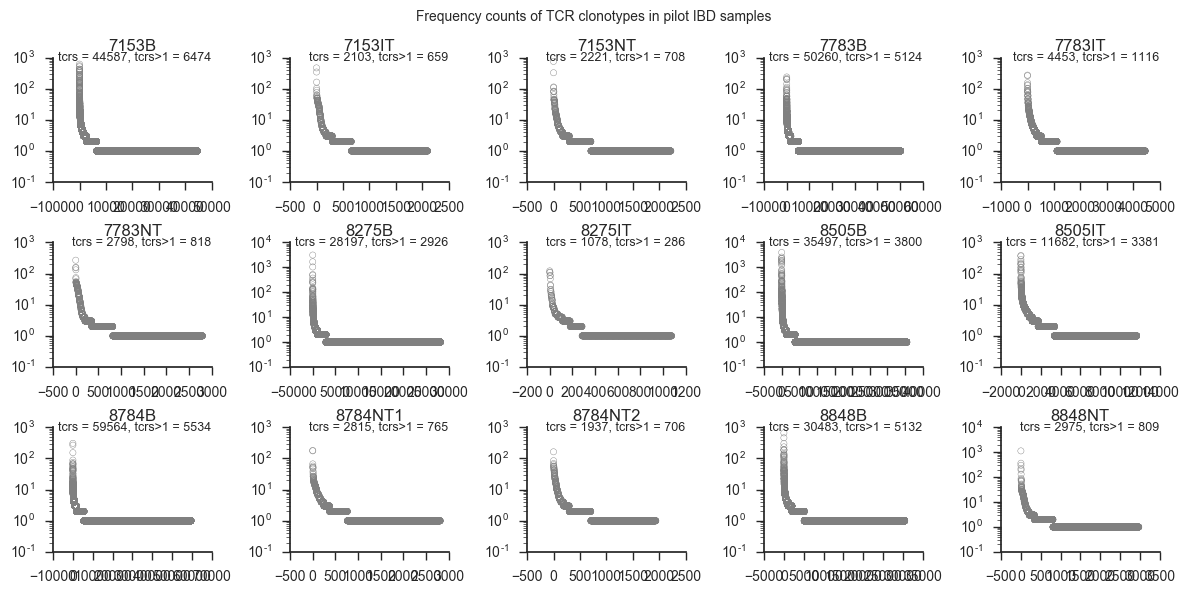

In [55]:
#Look at TCR clonotype (unique TCRb nucleotide sequence) frequency decay in different samples.

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCR clonotypes in pilot IBD samples")

counter = 1
for name, group in ibd_tcr_tab.groupby('sample'):
    ax = fig.add_subplot(3,5,counter)
    tmp = group.groupby('tcr_clonotype')['counts'].sum()
    plot_ind_freq(tmp, log=True) #plot counts, collapsed by tcr_clonotype
    plt.title(name)
    num_total = len(tmp)
    num_morethan_1 = sum(tmp > 1)
    plt.annotate('tcrs = {0}, tcrs>1 = {1}'.format(num_total, num_morethan_1), 
                xy=(1,0.95), xycoords='axes fraction', 
                horizontalalignment='right', verticalalignment='bottom',
                fontsize=9)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


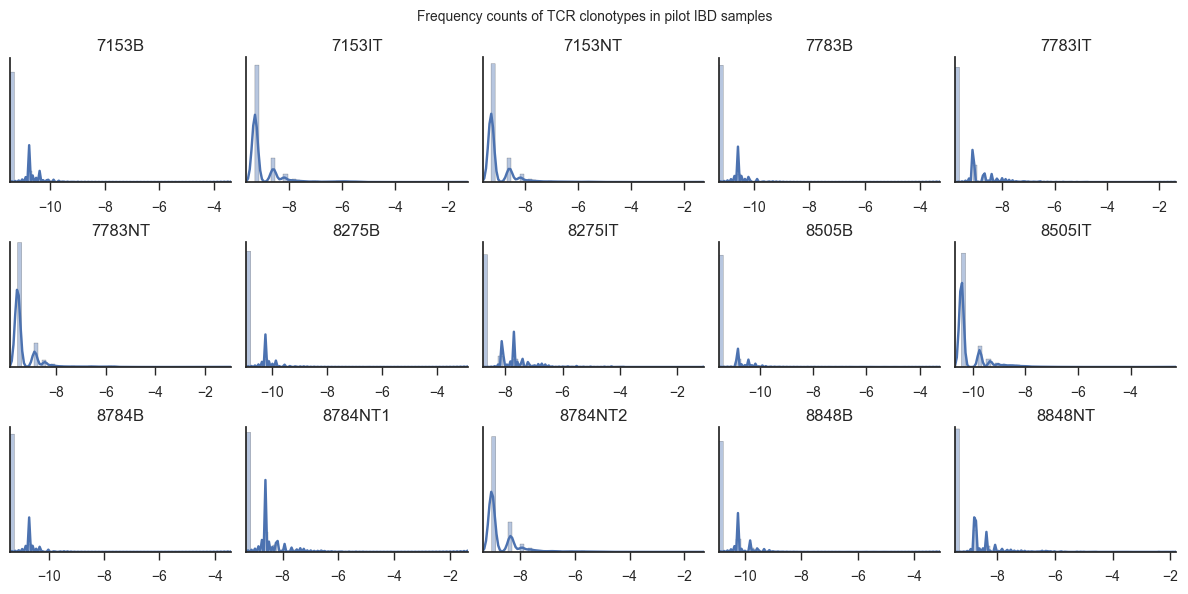

In [83]:
#Look at TCR clonotype frequency distributions

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCR clonotypes in pilot IBD samples")

counter = 1
for name, group in ibd_tcr_tab.groupby('sample'):
    ax = fig.add_subplot(3,5,counter)
    tmp = group.groupby('tcr_clonotype')['freq'].sum()
    sns.distplot(np.log(tmp.values))
    ax.yaxis.set_visible(False)
    ax.locator_params(axis='x', tight=True, nbins=5)
    plt.title(name)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

If we combine our sequences into TCR clonotypes (identical cdr3 nucleotide sequence and matching V and J segments), we see that there are now many more TCRs that register an abundance greater than 1 (~2x as many for most samples). And although this certainly shifts the frequency spectrum, we still see very peaked behavior in the data, which suggests that we're not going to be able to have a decent model for TCR clonotype distribution in this dataset.

In [56]:
overlap_num_htmp = df_pw_heatmap(ibd_tcr_tab, 'sample', overlap_num, 
                                 set_column='tcr_clonotype').apply(pd.to_numeric)

In [57]:
jaccard_htmp = df_pw_heatmap(ibd_tcr_tab, 'sample', jaccard_df, 
                             set_column='tcr_clonotype').apply(pd.to_numeric)

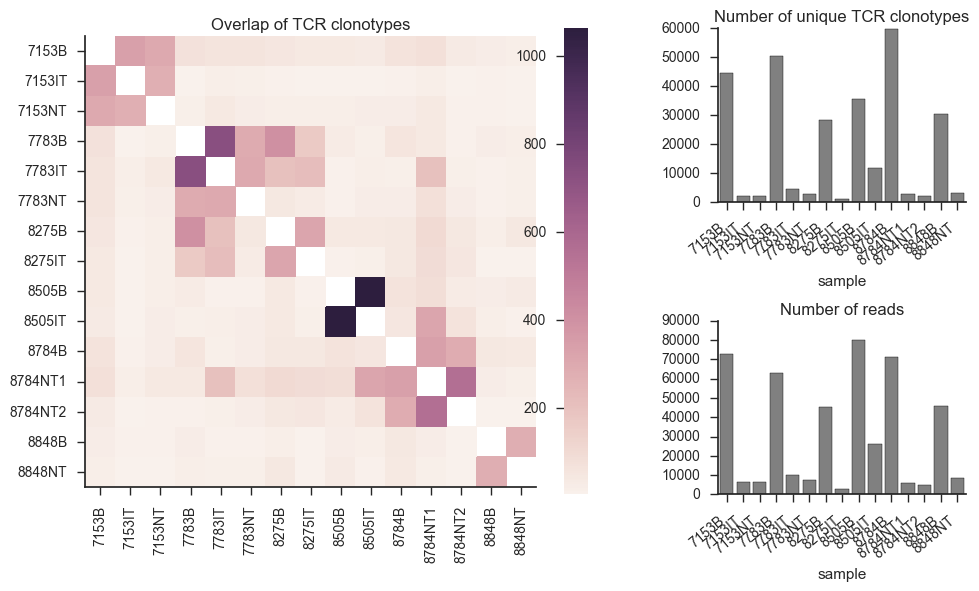

In [58]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(overlap_num_htmp, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Overlap of TCR clonotypes')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['tcr_clonotype'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique TCR clonotypes')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('Number of reads')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

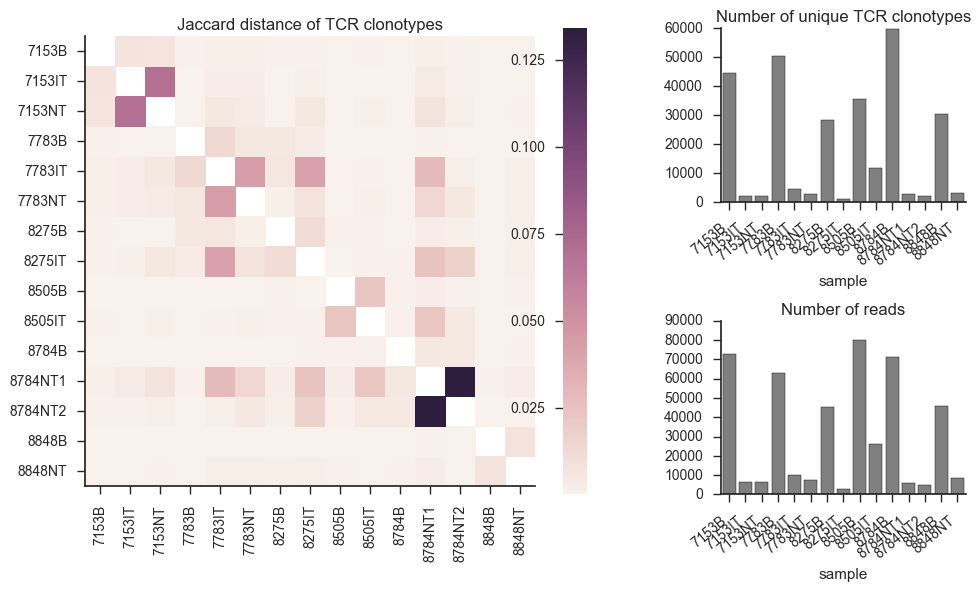

In [59]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(jaccard_htmp, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard distance of TCR clonotypes')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['tcr_clonotype'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique TCR clonotypes')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('Number of reads')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

In [117]:
jaccard_htmp_cdr3aa = df_pw_heatmap(ibd_tcr_tab, 'sample', jaccard_df, 
                             set_column='cdr3_aa').apply(pd.to_numeric)

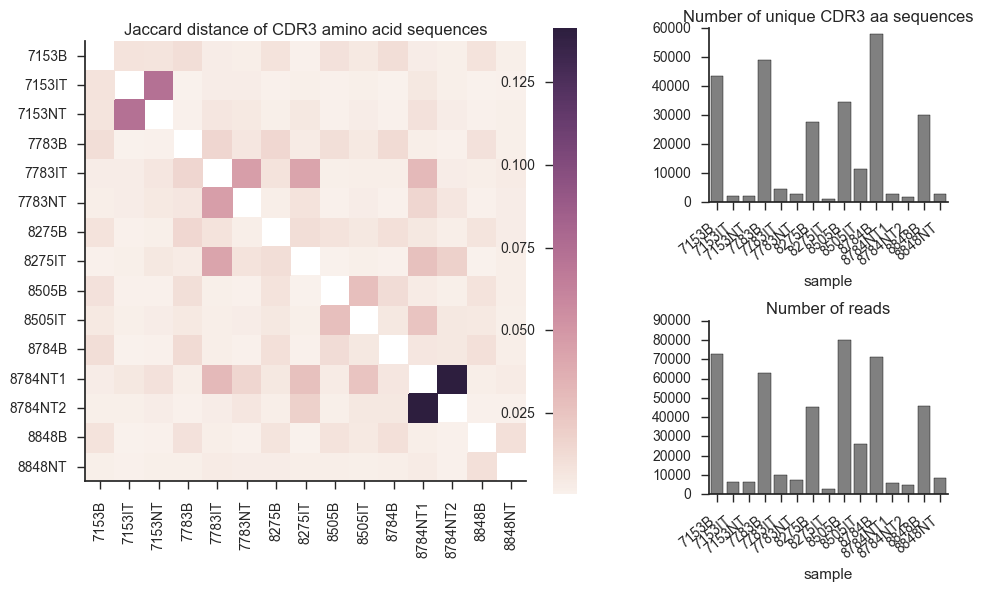

In [119]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(jaccard_htmp_cdr3aa, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard distance of CDR3 amino acid sequences')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['cdr3_aa'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique CDR3 aa sequences')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('Number of reads')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

So the overlap of TCR clonotypes seems to cluster by individual, when considering all TCRs and looking at TCR clonotypes. However, if only looking at CDR3 amino acid sequences, there is far less pattern beyond some pairs of biopsy replicates.

What are the colontypes that are shared ("public") across people?

In [47]:
#get TCR epitopes that are shared across individuals
tcr_epi_dict = {}
for name, group in ibd_tcr_tab.groupby('patient'):
    tcr_epi_dict[name] = set(group['tcr_epitope'])
tcr_epi_numpats = defaultdict(int)
for patient in tcr_epi_dict:
    for tcr in tcr_epi_dict[patient]:
        tcr_epi_numpats[tcr] += 1
tcr_epi_numpats = pd.DataFrame.from_dict(tcr_epi_numpats, orient='index')
tcr_epi_numpats = tcr_epi_numpats.rename(columns={0: 'num_patients'})
tcr_epi_numpats = tcr_epi_numpats.sort_values('num_patients', ascending=False)

#tcr_epi_numpats is now a table with information on the number of patients each TCR epitope
#was observed in

#get TCR epitopes that are shared across individuals in blood samples
tcr_epi_dict_bld = {}
tmp_tab = ibd_tcr_tab.loc[ibd_tcr_tab['tissue'] == 'blood']
for name, group in tmp_tab.groupby('patient'):
    tcr_epi_dict[name] = set(group['tcr_epitope'])
numpats_bld = defaultdict(int)
for patient in tcr_epi_dict:
    for tcr in tcr_epi_dict[patient]:
        numpats_bld[tcr] += 1
numpats_bld = pd.DataFrame.from_dict(numpats_bld, orient='index')
numpats_bld = numpats_bld.rename(columns={0: 'num_patients_blood'})

#get TCR epitopes that are shared across individuals in biopsy samples
tcr_epi_dict_bld = {}
tmp_tab = ibd_tcr_tab.loc[ibd_tcr_tab['tissue'] == 'biopsy']
for name, group in tmp_tab.groupby('patient'):
    tcr_epi_dict[name] = set(group['tcr_epitope'])
numpats_biop = defaultdict(int)
for patient in tcr_epi_dict:
    for tcr in tcr_epi_dict[patient]:
        numpats_biop[tcr] += 1
numpats_biop = pd.DataFrame.from_dict(numpats_biop, orient='index')
numpats_biop = numpats_biop.rename(columns={0: 'num_patients_biopsy'})

tcr_epi_numpats = pd.concat([tcr_epi_numpats, tmp_numpats, numpats_biop], axis=1)
tcr_epi_numpats = tcr_epi_numpats.fillna(0)

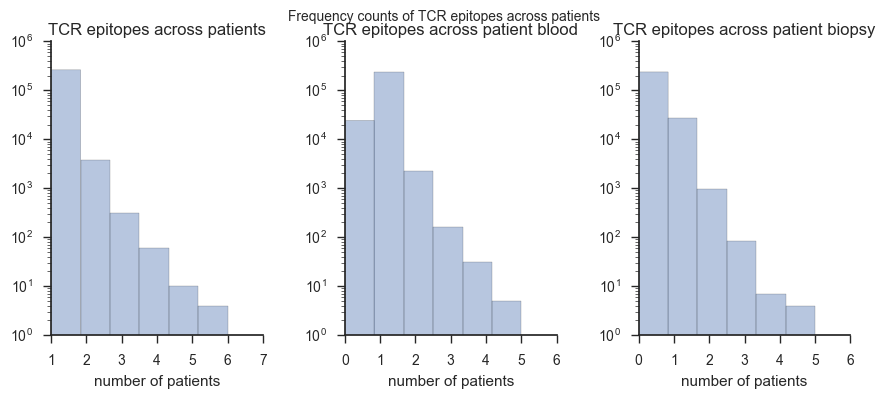

In [58]:
#plot sharedness of TCR epitopes
fig = plt.figure(figsize=(9, 4))
plt.suptitle("Frequency counts of TCR epitopes across patients")

ax = fig.add_subplot(1,3,1)
sns.distplot(tcr_epi_numpats['num_patients'], kde=False, bins=6)
plt.title('TCR epitopes across patients')
ax.set_xlabel('number of patients')
plt.yscale('log')

ax = fig.add_subplot(1,3,2)
sns.distplot(tcr_epi_numpats['num_patients_blood'], kde=False, bins=6)
plt.title('TCR epitopes across patient blood')
ax.set_xlabel('number of patients')
plt.yscale('log')

ax = fig.add_subplot(1,3,3)
sns.distplot(tcr_epi_numpats['num_patients_biopsy'], kde=False, bins=6)
plt.title('TCR epitopes across patient biopsy')
ax.set_xlabel('number of patients')
plt.yscale('log')

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So we can observe that there are a small subset of TCR epitopes that are public, some shared across all patients (although from a mix of blood and biopsy samples) or all blood/biopsy samples, and many more that are unique for that individual.

1. Does selection or recombination bias shape these public TCRs?
2. What is the likelihood of the public TCRs?
3. Do these TCRs have any similarity to published TCRs?
4. How are public TCRs in biopsy samples versus blood samples or disease versus healthy patients
5. Do public TCRs make up a greater portion of biopsy samples or blood samples?
6. Do public TCRs make up a greater frequency/abundance in TCR repertoires from biopsy samples than blood samples?

In [62]:
#get lists of public TCRs over all samples, only blood, only biopsy
pub_tcrepi2 = tcr_epi_numpats.loc[tcr_epi_numpats['num_patients'] > 1].index.values
pub_tcrepi_bld2 = tcr_epi_numpats.loc[tcr_epi_numpats['num_patients_blood'] > 1].index.values
pub_tcrepi_biop2 = tcr_epi_numpats.loc[tcr_epi_numpats['num_patients_biopsy'] > 1].index.values

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


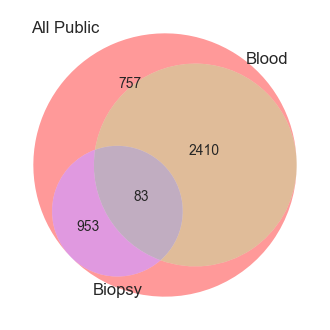

In [67]:
plt_venn.venn3([set(pub_tcrepi2), set(pub_tcrepi_bld2), set(pub_tcrepi_biop2)],
              set_labels = ('All Public', 'Blood', 'Biopsy'))

In [104]:
#What fraction of biopsy TCRs are public?
freq_biopsy = {} #frequency of biopsy TCRs being public among biopsy samples
for name, group in ibd_tcr_tab.loc[ibd_tcr_tab['tissue'] == 'biopsy'].groupby('sample'):
    tcrs = group['tcr_epitope'].unique()
    freq_public = len(set(tcrs).intersection(pub_tcrepi_biop2)) / len(tcrs)
    freq_biopsy[name] = freq_public

freq_blood = {} #frequency of blood TCRs being public among blood samples
for name, group in ibd_tcr_tab.loc[ibd_tcr_tab['tissue'] == 'blood'].groupby('sample'):
    tcrs = group['tcr_epitope'].unique()
    freq_public = len(set(tcrs).intersection(pub_tcrepi_bld2)) / len(tcrs)
    freq_blood[name] = freq_public

freq_all = {} #frequency of sample TCRs being public among samples
for name, group in ibd_tcr_tab.groupby('sample'):
    tcrs = group['tcr_epitope'].unique()
    freq_public = len(set(tcrs).intersection(pub_tcrepi2)) / len(tcrs)
    freq_all[name] = freq_public

In [112]:
tmp = pd.DataFrame.from_dict(freq_biopsy, orient='index')
tmp = tmp.rename(columns={0: 'pubfreq'})
tmp['tissue'] = 'biopsy'
tmp1 = pd.DataFrame.from_dict(freq_blood, orient='index')
tmp1 = tmp1.rename(columns={0: 'pubfreq'})
tmp1['tissue'] = 'blood'
tmp = pd.concat([tmp, tmp1], axis = 0)

In [98]:
freq_all_tab = pd.DataFrame.from_dict(freq_all, orient='index')
freq_all_tab = freq_all_tab.rename(columns={0: 'pubfreq'})
freq_all_tab['x_label'] = 'all'
freq_all_tab = pd.concat([freq_all_tab, sample_metadata['tissue']], axis=1)

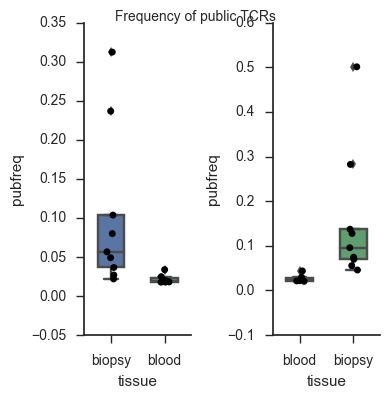

In [114]:
#plot frequency of public TCR epitopes
fig = plt.figure(figsize=(4, 4))
plt.suptitle("Frequency of public TCRs")

ax = fig.add_subplot(1,2,1)
sns.stripplot(x='tissue', y='pubfreq', data=tmp, jitter=True, color='black')
sns.boxplot(x='tissue', y='pubfreq', data=tmp, width=.5)

ax = fig.add_subplot(1,2,2)
sns.stripplot(x='tissue', y='pubfreq', data=freq_all_tab, jitter=True, color='black')
sns.boxplot(x='tissue', y='pubfreq', data=freq_all_tab, width=.5)

plt.tight_layout()
sns.despine()

In [118]:
#do public TCRs tend to have greater abundances than private TCRs in different tissues?
ibd_tcr_tab_cp = ibd_tcr_tab[['sample', 'counts', 'tissue', 'freq', 'tcr_epitope', 'tcr_clonotype']]
ibd_tcr_tab_cp['public_all'] = ibd_tcr_tab_cp['tcr_epitope'].apply(lambda x: x in pub_tcrepi2)
ibd_tcr_tab_cp['public_biopsy'] = ibd_tcr_tab_cp['tcr_epitope'].apply(lambda x: x in pub_tcrepi_biop2)
ibd_tcr_tab_cp['public_blood'] = ibd_tcr_tab_cp['tcr_epitope'].apply(lambda x: x in pub_tcrepi_bld2)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

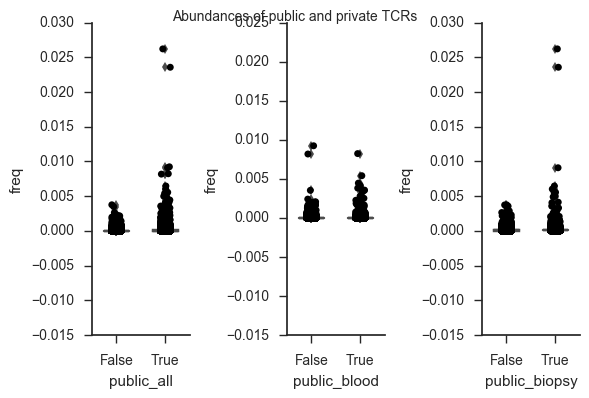

In [122]:
#plot abundances of public/private TCR epitopes
fig = plt.figure(figsize=(6, 4))
plt.suptitle("Abundances of public and private TCRs")

ax = fig.add_subplot(1,3,1)
sns.stripplot(x='public_all', y='freq', data=ibd_tcr_tab_cp, jitter=True, color='black')
sns.boxplot(x='public_all', y='freq', data=ibd_tcr_tab_cp, width=.5)

ax = fig.add_subplot(1,3,2)
tmp = ibd_tcr_tab_cp.loc[ibd_tcr_tab_cp['tissue'] == 'blood']
sns.stripplot(x='public_blood', y='freq', data=tmp, jitter=True, color='black')
sns.boxplot(x='public_blood', y='freq', data=tmp, width=.5)

ax = fig.add_subplot(1,3,3)
tmp = ibd_tcr_tab_cp.loc[ibd_tcr_tab_cp['tissue'] == 'biopsy']
sns.stripplot(x='public_biopsy', y='freq', data=tmp, jitter=True, color='black')
sns.boxplot(x='public_biopsy', y='freq', data=tmp, width=.5)

plt.tight_layout()
sns.despine()

In [124]:
#ibd_tcr_tab
tmp = ibd_tcr_tab.groupby('tcr_clonotype').size()


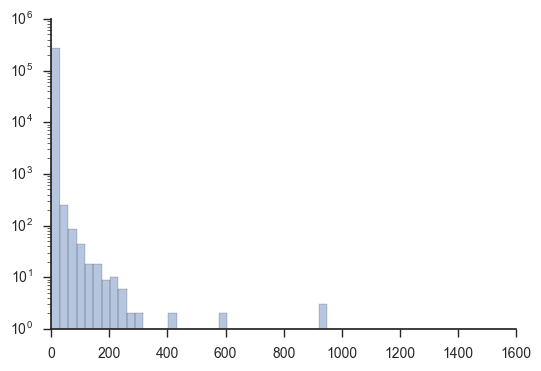

In [128]:
sns.distplot(tmp, kde=False)
sns.despine()
plt.yscale('log')

In [125]:
tmp

tcr_clonotype
tcr_0         1
tcr_1         4
tcr_10        1
tcr_100       1
tcr_10000     1
tcr_100000    1
tcr_100001    1
tcr_100002    1
tcr_100004    2
tcr_100005    1
tcr_100006    1
tcr_100007    1
tcr_100008    1
tcr_100009    1
tcr_10001     1
tcr_100010    1
tcr_100011    1
tcr_100012    1
tcr_100013    1
tcr_100014    1
tcr_100015    1
tcr_100016    1
tcr_100017    1
tcr_100018    1
tcr_100019    1
tcr_100020    1
tcr_100021    1
tcr_100024    1
tcr_100025    1
tcr_100027    1
             ..
tcr_99967     1
tcr_99968     1
tcr_99969     1
tcr_99970     1
tcr_99971     1
tcr_99972     1
tcr_99973     1
tcr_99975     1
tcr_99976     1
tcr_99977     1
tcr_99978     1
tcr_99979     1
tcr_9998      1
tcr_99980     1
tcr_99981     1
tcr_99982     1
tcr_99983     1
tcr_99984     1
tcr_99987     1
tcr_99988     1
tcr_99989     1
tcr_9999      1
tcr_99990     3
tcr_99991     2
tcr_99992     1
tcr_99994     1
tcr_99995     2
tcr_99996     1
tcr_99997     1
tcr_99999     1
dtype: int

## V-J usage across different samples
If we start at a coarse level (V and J segment usage) what do we observe?

1. Do frequencies of V (and J) usage change across samples?
2. Do certain V and J segments get paired more often?

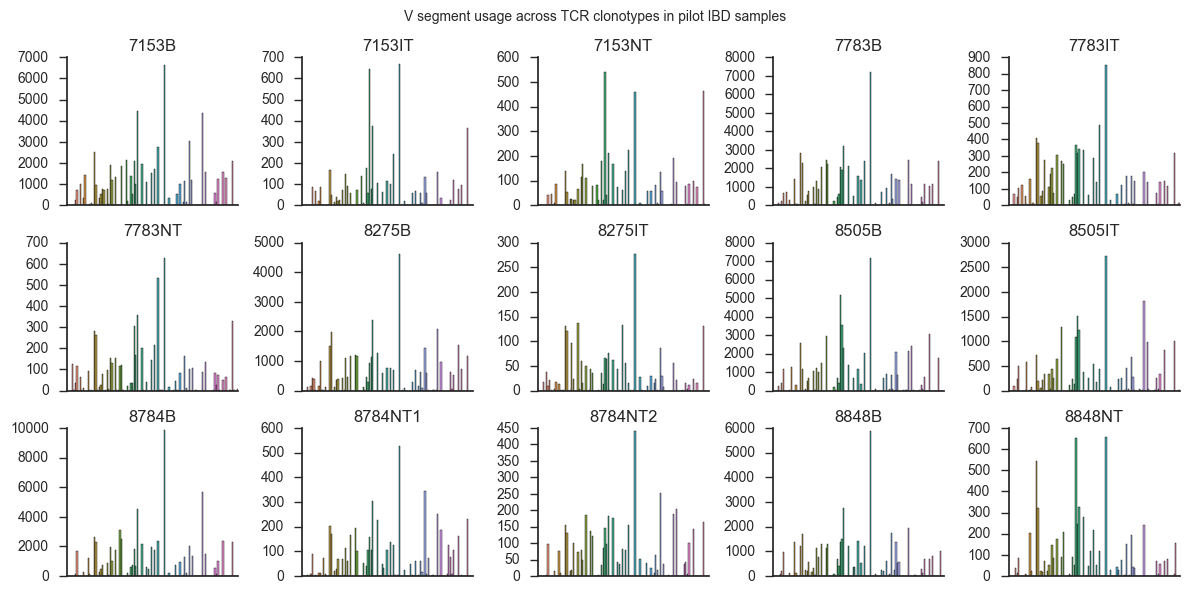

In [31]:
#plot the number of TCRs with any given V segment for each sample
v_df = pd.DataFrame() #get the same vector of v segment usage for all samples
for name, group in ibd_tcr_tab_sample_groupby:
    v_counts = group.groupby('v').size()
    v_counts = v_counts.rename(name)
    v_df = pd.concat([v_df, v_counts], axis=1)
v_df = v_df.fillna(0)

fig = plt.figure(figsize=(12, 6))
plt.suptitle("V segment usage across TCR clonotypes in pilot IBD samples")

counter = 1
for column in v_df:
    ax = fig.add_subplot(3,5,counter)
    sns.barplot(x=v_df.index.values, y=v_df[column].values)
    plt.title(column)
    counter += 1
    ax.xaxis.set_visible(False)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [21]:
#Is the overlap in unique v segments nearly complete for all samples?
v_jac_htmp = df_pw_heatmap(ibd_tcr_tab, 'sample', jaccard_df, 
                             set_column='v').apply(pd.to_numeric)

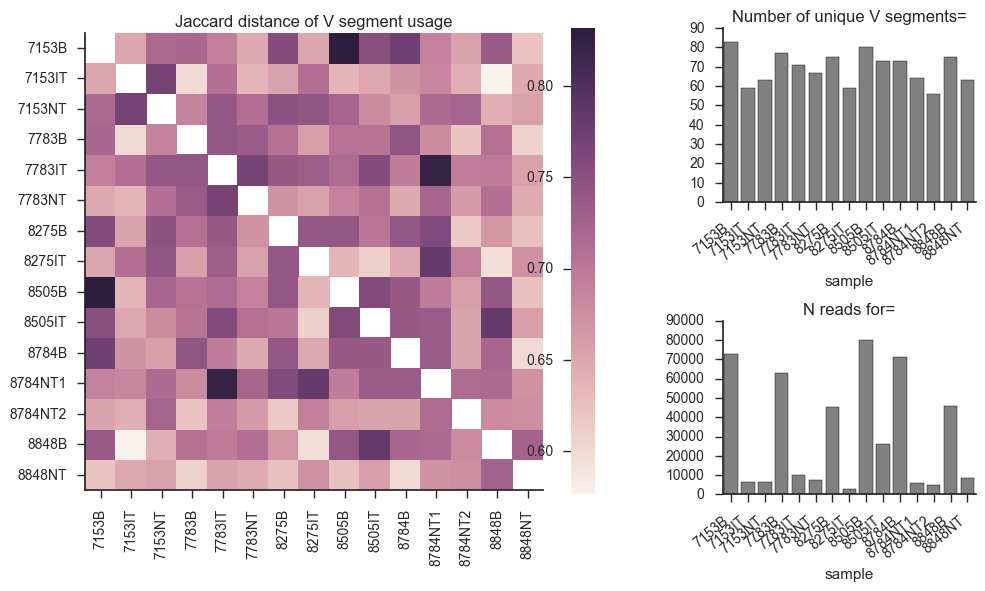

In [108]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(v_jac_htmp, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard distance of V segment usage')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['v'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique V segments')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_tcr_tab_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('N reads for=')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

So the overlap in v segments is pretty high (~0.6-0.8) but the overlap is never complete, indicating that theat either individuals are different from each other in their v segment usage OR that the sampling is insufficient to capture commonalities. V segment usage is also biased by the individuals HLA type ([ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2118988/)), and the HLA type of these patients is unknown, but very likely different. There is no easily visible pattern of V segment usage overlap between different samples. Perhaps biopsy samples are more similar and blood samples are more similar.

In [88]:
#look at jaccard similarity within versus between individuals and biopsy versus blood
pw_combs = list(combinations(sample_metadata.index, 2))

within_ind = [x for x in pw_combs 
              if sample_metadata.loc[x[0]]['patient'] ==
              sample_metadata.loc[x[1]]['patient']]
within_ind_jac = [v_jac_htmp.loc[x[0]][x[1]] for x in within_ind]

btw_ind = [x for x in pw_combs 
           if sample_metadata.loc[x[0]]['patient'] != 
           sample_metadata.loc[x[1]]['patient']]
btw_ind_jac = [v_jac_htmp.loc[x[0]][x[1]] for x in btw_ind]

blood = [x for x in pw_combs 
         if (sample_metadata.loc[x[0]]['tissue'] == 'blood') & 
         (sample_metadata.loc[x[1]]['tissue'] == 'blood')]
blood_jac = [v_jac_htmp.loc[x[0]][x[1]] for x in blood]

biopsy = [x for x in pw_combs 
          if (sample_metadata.loc[x[0]]['tissue'] == 'biopsy') & 
          (sample_metadata.loc[x[1]]['tissue'] == 'biopsy')]
biopsy_jac = [v_jac_htmp.loc[x[0]][x[1]] for x in biopsy]

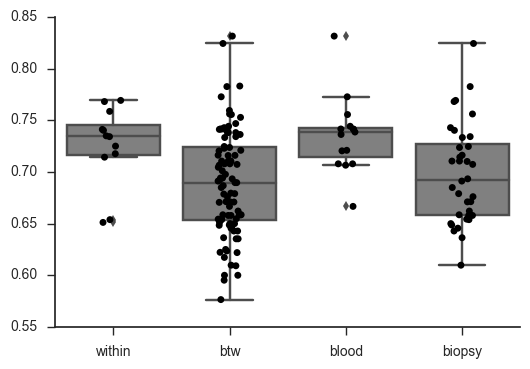

In [90]:
#plot different jaccard similarities
x = ['within'] * len(within_ind) + ['btw'] * len(btw_ind) + ['blood'] * len(blood) + ['biopsy'] * len(biopsy)
y = within_ind_jac + btw_ind_jac + blood_jac + biopsy_jac
sns.stripplot(x, y, jitter=True, color='black')
sns.boxplot(x, y, color='grey')
sns.despine()

So over all TCRs, the overlap in V segments within individuals looks like it's probably higher than between individuals, which is probably expected. We see perhaps a similar bias in the blood, although this is likely a sampling effect of blood samples having much greater depth and biopsy samples. Looking at the similarity in frequencies of different v segments (not just the presence/absence) might shed some light on this.

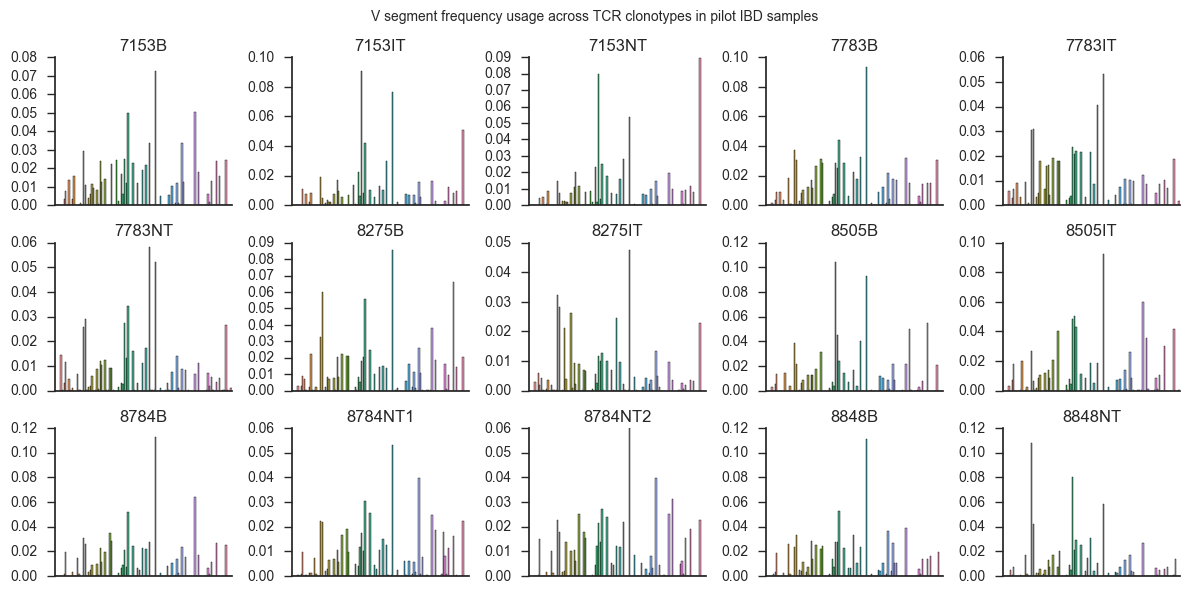

In [32]:
#Look at frequency of V segment usage across samples.
v_df = pd.DataFrame() #get the same vector of v segment usage for all samples
for name, group in ibd_tcr_tab_sample_groupby:
    v_counts = group.groupby('v')['freq'].sum()
    v_counts = v_counts.rename(name)
    v_df = pd.concat([v_df, v_counts], axis=1)
v_df = v_df.fillna(0)

fig = plt.figure(figsize=(12, 6))
plt.suptitle("V segment frequency usage across TCR clonotypes in pilot IBD samples")

counter = 1
for column in v_df:
    ax = fig.add_subplot(3,5,counter)
    sns.barplot(x=v_df.index.values, y=v_df[column].values)
    plt.title(column)
    ax.xaxis.set_visible(False)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

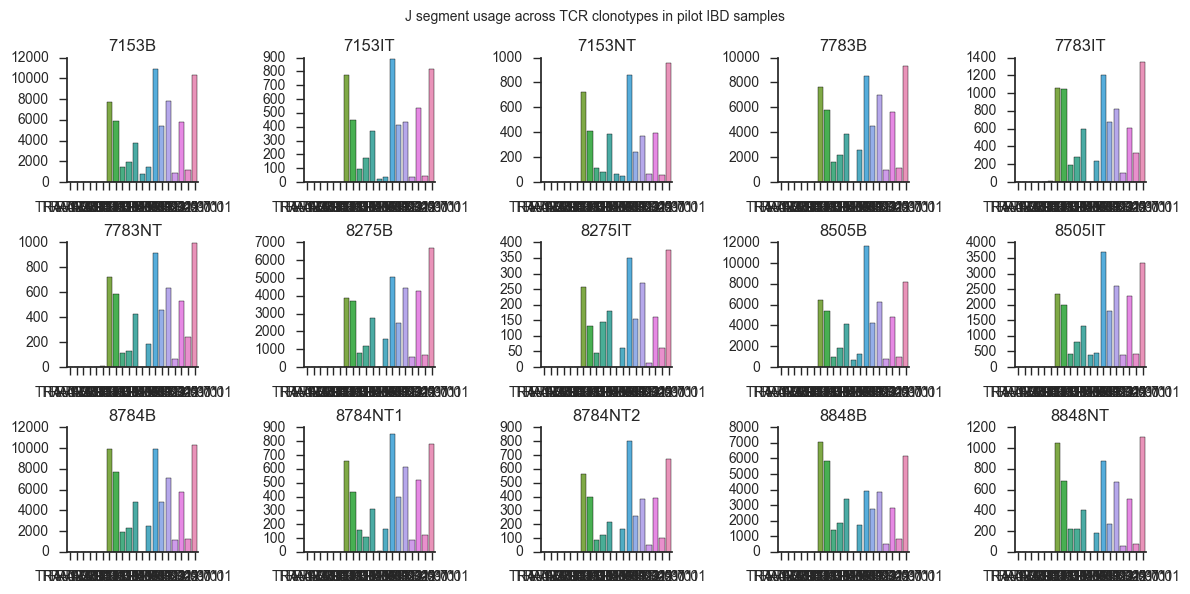

In [18]:
#plot the number of TCRs with any given J segment for each sample
j_df = pd.DataFrame() #get the same vector of j segment usage for all samples
for name, group in ibd_tcr_tab_sample_groupby:
    j_counts = group.groupby('j').size()
    j_counts = j_counts.rename(name)
    j_df = pd.concat([j_df, j_counts], axis=1)
j_df = j_df.fillna(0)

fig = plt.figure(figsize=(12, 6))
plt.suptitle("J segment usage across TCR clonotypes in pilot IBD samples")

counter = 1
for column in j_df:
    ax = fig.add_subplot(3,5,counter)
    sns.barplot(x=j_df.index.values, y=j_df[column].values)
    plt.title(column)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [100]:
#Is the overlap in unique j segments nearly complete for all samples?
j_jac_htmp = df_pw_heatmap(ibd_tcr_tab, 'sample', jaccard_df, 
                             set_column='j').apply(pd.to_numeric)

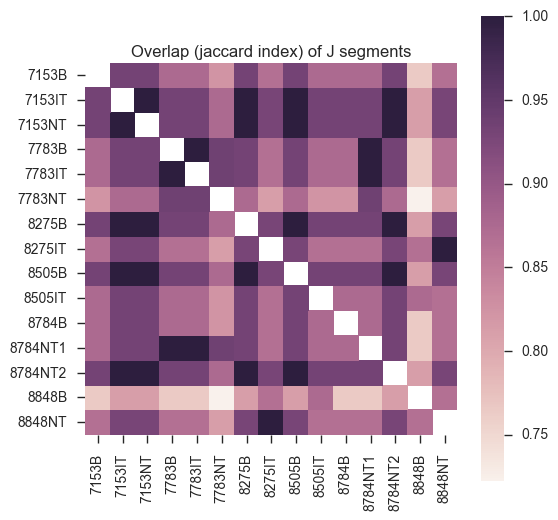

In [101]:
fig = plt.figure(figsize=(6, 6))
ax1 = sns.heatmap(j_jac_htmp, square=True, 
            vmin=None)
ax1.set_title('Overlap (jaccard index) of J segments')

## Look at TCR clonotypes with a threshold of abundance

By taking out the very long tail of singly detected TCRs, are we able to make more reasonable comparisons between samples?

Key Questions:
1. What abundance suggests an expanded TCR clone?
2. 

In [21]:
#make a df with only TCR clonotypes that occur more than once in ea sample
ibd_cln_grtn1 = pd.DataFrame() 
for name, group in ibd_tcr_tab_sample_groupby:
    tmp = group.groupby('tcr_clonotype')['counts'].sum()
    clones_over_1 = tmp.loc[tmp > 1].index.values
    tmp_tab = group[group['tcr_clonotype'].isin(clones_over_1)]
    ibd_cln_grtn1 = pd.concat([ibd_cln_grtn1, tmp_tab])

In [22]:
ibd_cln_grtn1_sample_groupby = ibd_cln_grtn1.groupby('sample')

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


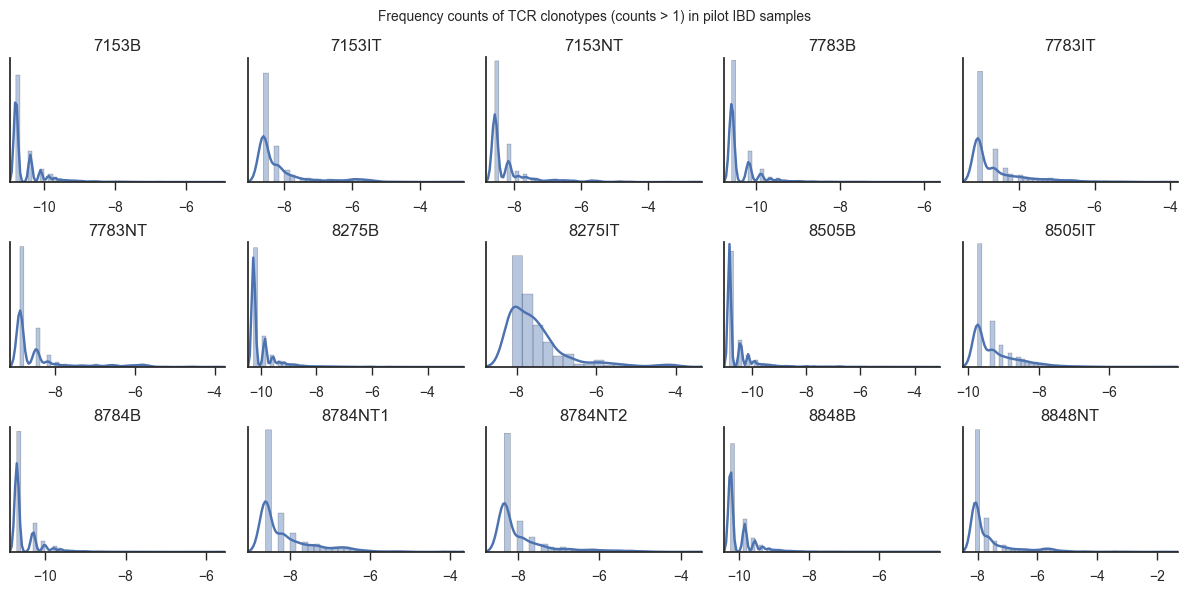

In [109]:
#Look at TCR clonotype frequency distributions
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCR clonotypes (counts > 1) in pilot IBD samples")

counter = 1
for name, group in ibd_cln_grtn1_sample_groupby:
    ax = fig.add_subplot(3,5,counter)
    tmp = group.groupby('tcr_clonotype')['freq'].sum()
    sns.distplot(np.log(tmp.values))
    ax.yaxis.set_visible(False)
    ax.locator_params(axis='x', tight=True, nbins=5)
    plt.title(name)
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

If we only look at those TCR clonotypes that are present with greater than one count, we see the expected exponential decrease in frequency across different orders of abundance. 8275IT is surprisingly not peaky, likely because it had a large number of reads, but not that rare of TCRs detected (only down to exp(-8) instead of exp(-11) like the other blood samples). We still see no hint or suggestion of the lognormal distribution observed in some of the Adaptive datasets, which appear to be sequences to saturation. For that matter, it's suspect whether that distribution is more a byproduct of sequencing error and sequencing to saturation or a true biological phenomena.

In [103]:
jaccard_htmp_1 = df_pw_heatmap(ibd_cln_grtn1, 'sample', jaccard_df, 
                             set_column='tcr_clonotype').apply(pd.to_numeric)

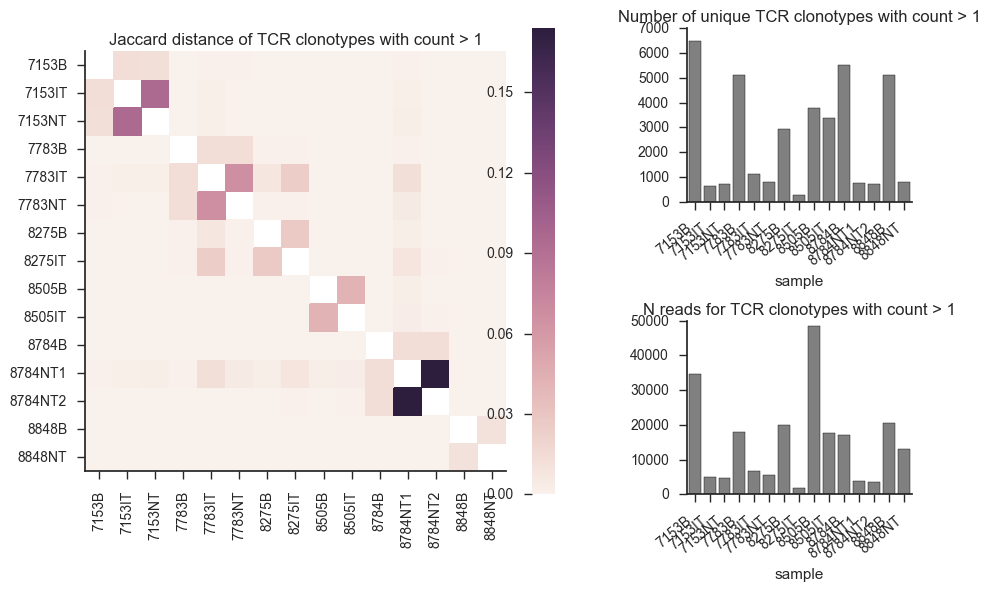

In [105]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(jaccard_htmp_1, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard distance of TCR clonotypes with count > 1')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_cln_grtn1_sample_groupby.apply(lambda x: x['tcr_clonotype'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique TCR clonotypes with count > 1')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_cln_grtn1_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('N reads for TCR clonotypes with count > 1')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

So in the more frequent TCRs we can clearly see clustering by both individual and tissue, as blood samples appear to have less overlap than biopsy samples, which cluster more closely together. This clustering is more pronounced than when looking at the full TCR repetoire. 

In [106]:
v_segment_htmp_1 = df_pw_heatmap(ibd_cln_grtn1, 'sample', jaccard_df, 
                             set_column='v').apply(pd.to_numeric)

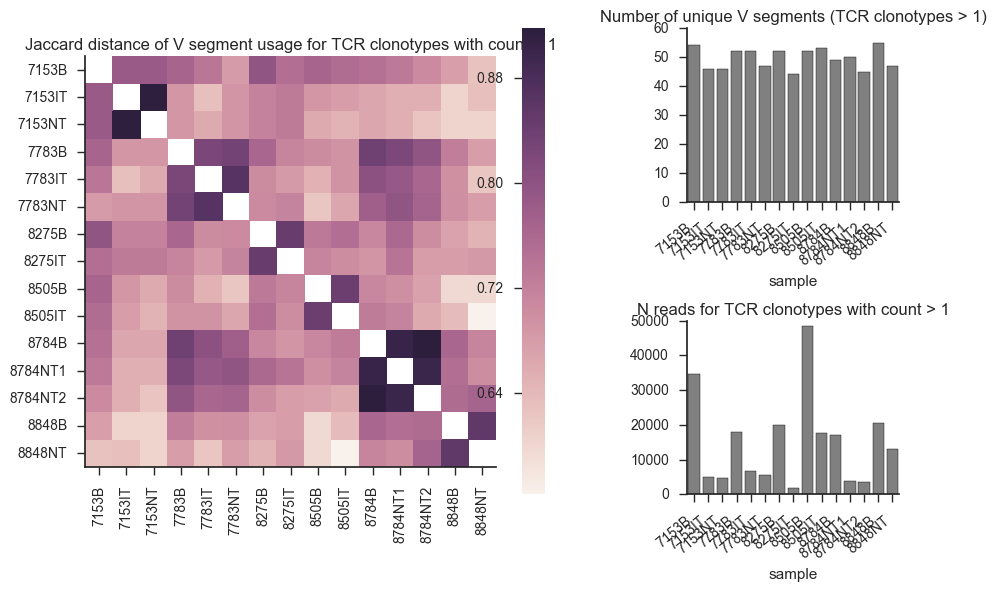

In [107]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(v_segment_htmp_1, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard distance of V segment usage for TCR clonotypes with count > 1')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_cln_grtn1_sample_groupby.apply(lambda x: x['v'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('Number of unique V segments (TCR clonotypes > 1)')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_cln_grtn1_sample_groupby.apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('N reads for TCR clonotypes with count > 1')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

Unlike over all TCRs (which just looked like a bunch of noise), this V segment analysis in TCR clonotypes with more than 1 counts appears a little more informative. Individuals cluster together and like tissues seems to look more similar. We see some blocks of increased over lap between 8784 and 7783, which we saw hints of in the TCR data. In this fraction of the TCRs as well (things observed more than once) the total number of different V segments identified is more even across samples. The actual magnitudes of overlap don't look much higher, suggesting that perhaps everyone uses each V segment about the same in the naive or diverse TCR repertoire, but the ones that are more common (which may be recently or previously expanded clones) are the more pertinent signature of antigen exposure.

This clustering may or may not be also driven by the genetics of each host, which is known to produce unique rates of V segment usage [link](https://www.nature.com/articles/ncomms11112). However, because we're only seeing this clustering in the more abundant TCR clonotypes (not all TCR clonotypes overall), it could also be a product of each individual's antigen exposure, past or present.

In [39]:
#look at covariance of V segment usage within a person and between people
v_seg_freq = ibd_cln_grtn1.groupby(['sample', 'v'])['freq'].sum()

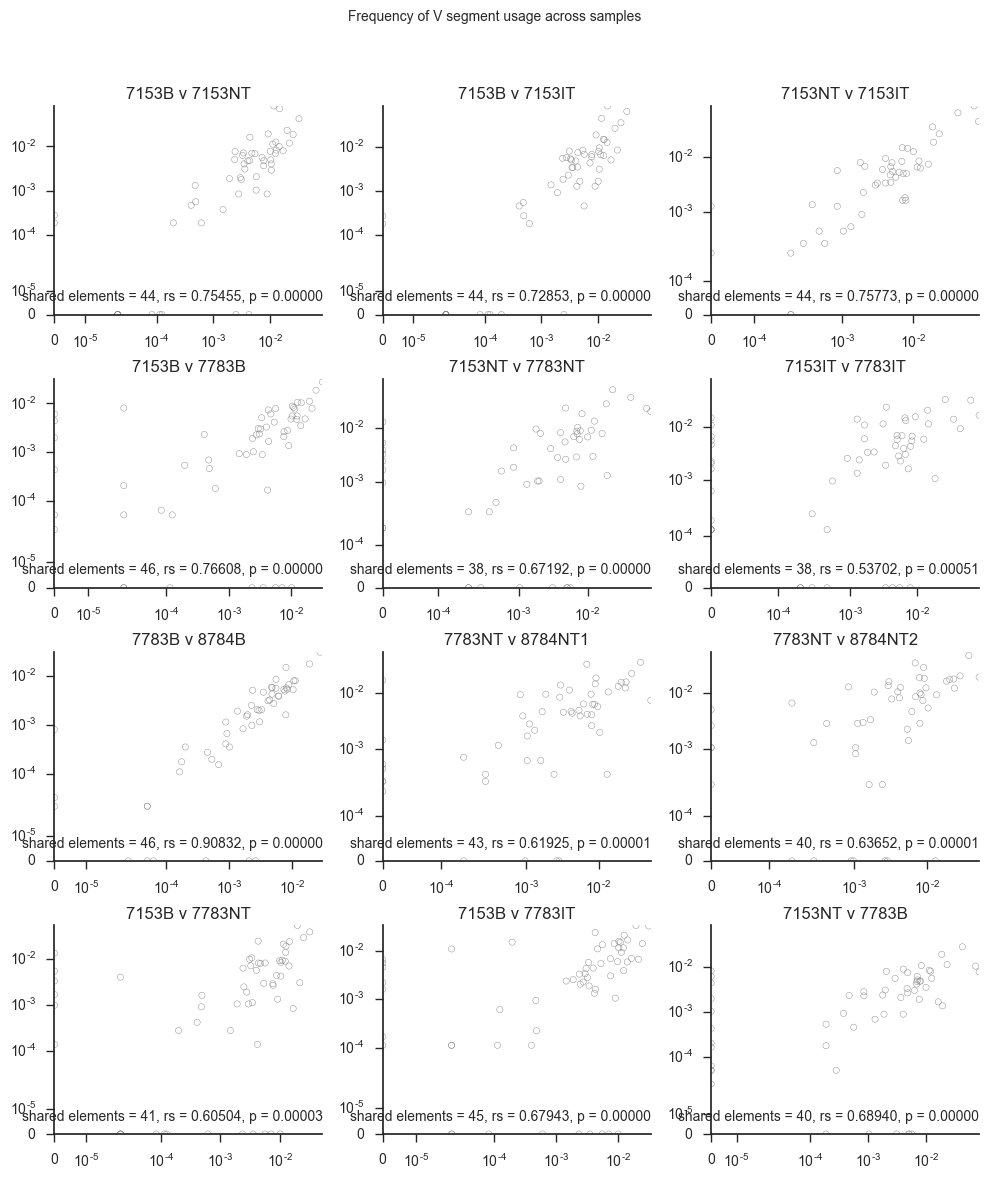

In [40]:
sample_pairs = [('7153B', '7153NT'), ('7153B', '7153IT'), ('7153NT', '7153IT'),
               ('7153B', '7783B'), ('7153NT', '7783NT'), ('7153IT', '7783IT'),
               ('7783B', '8784B'), ('7783NT', '8784NT1'), ('7783NT', '8784NT2'),
               ('7153B', '7783NT'), ('7153B', '7783IT'), ('7153NT', '7783B')]

fig = plt.figure(figsize=(10, 12))
plt.suptitle("Frequency of V segment usage across samples")

counter = 1
for pair in sample_pairs:
    ax = fig.add_subplot(4,3,counter)
    x_tmp = v_seg_freq[pair[0]]
    y_tmp = v_seg_freq[pair[1]]
    plot_freq_comparison(x_tmp, y_tmp)
    plt.title(pair[0] + ' v ' + pair[1])
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So the frequency of v segment usage across samples (when considering only TCR clonotypes that appear more than once in any given sample) agrees very well over different tissues (blood, normal biopsy, and inflamd biopsy) and across individuals (looking at the same tissue) and across individuals and tissues (looking at different tissues over different individuals. So even though V segment overlap has a clear individual signature, overall v segment usage and frequency appears to be conserved between tissues and people.

In [34]:
#look at covariance of TCR clonotypes within a person and between people
tmp = ibd_cln_grtn1.groupby(['sample', 'tcr_clonotype'])['freq'].sum()

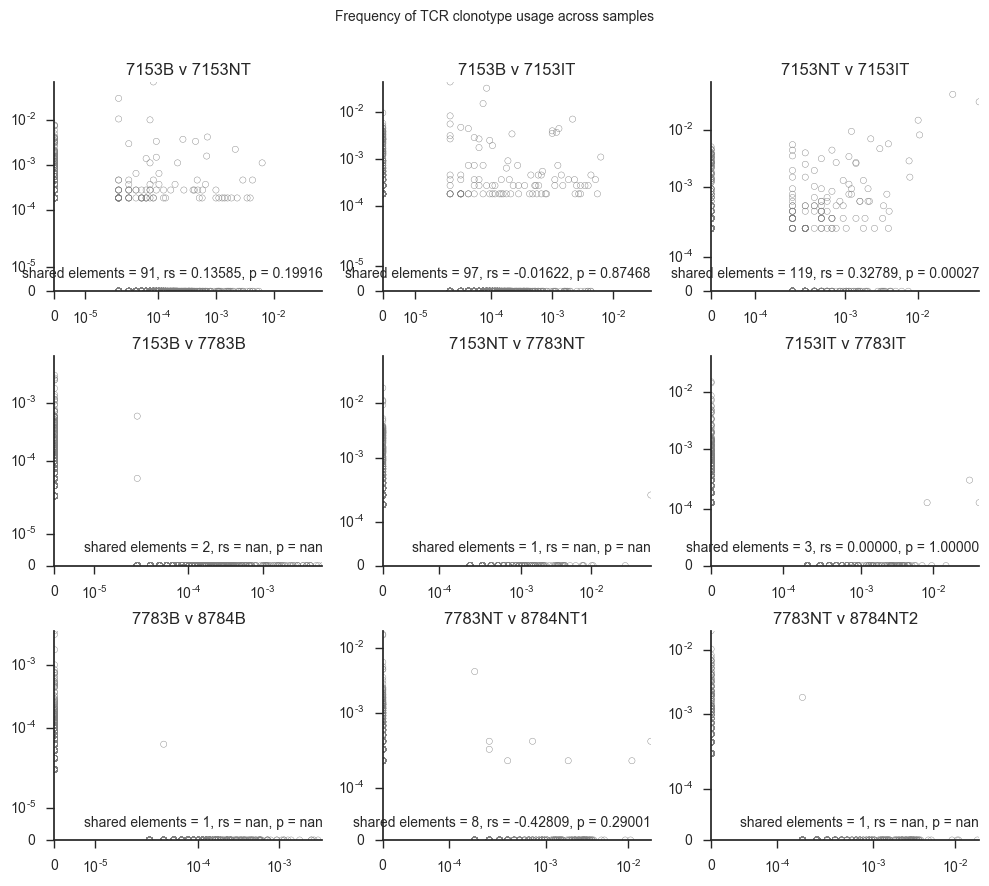

In [35]:
sample_pairs = [('7153B', '7153NT'), ('7153B', '7153IT'), ('7153NT', '7153IT'),
               ('7153B', '7783B'), ('7153NT', '7783NT'), ('7153IT', '7783IT'),
               ('7783B', '8784B'), ('7783NT', '8784NT1'), ('7783NT', '8784NT2')]

fig = plt.figure(figsize=(10, 9))
plt.suptitle("Frequency of TCR clonotype usage across samples")

counter = 1
for pair in sample_pairs:
    ax = fig.add_subplot(3,3,counter)
    x_tmp = tmp[pair[0]]
    y_tmp = tmp[pair[1]]
    plot_freq_comparison(x_tmp, y_tmp)
    plt.title(pair[0] + ' v ' + pair[1])
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

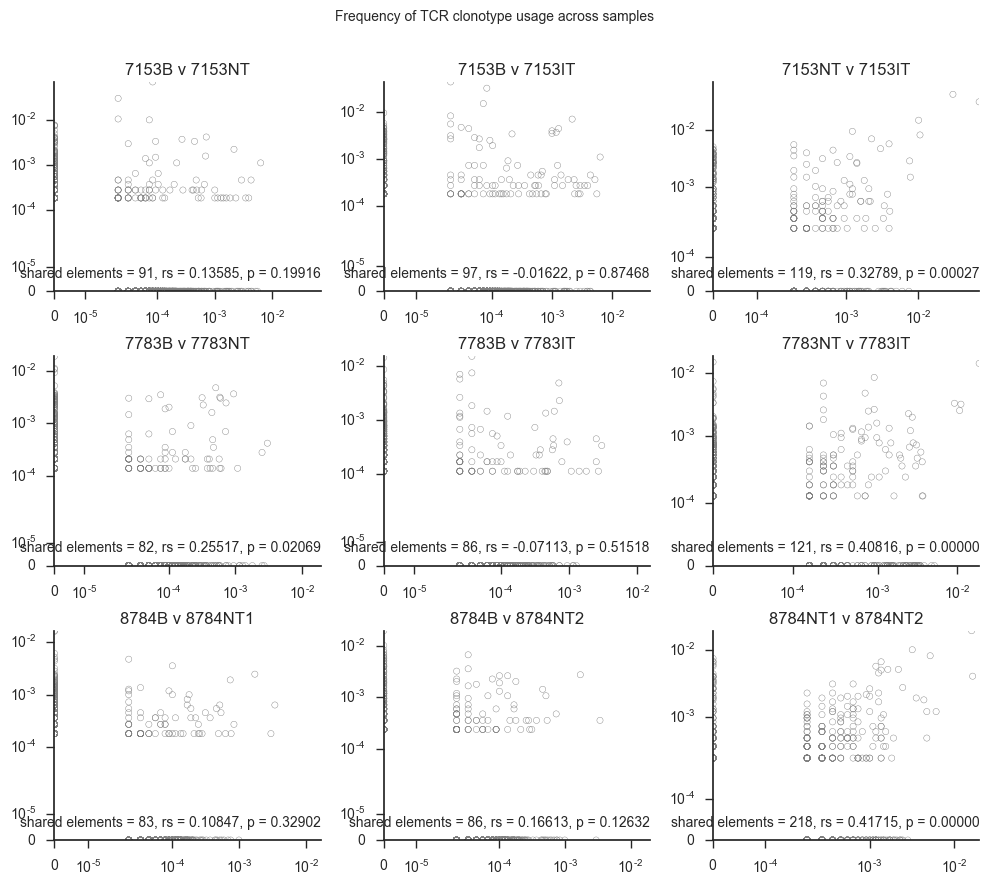

In [36]:
sample_pairs = [('7153B', '7153NT'), ('7153B', '7153IT'), ('7153NT', '7153IT'),
               ('7783B', '7783NT'), ('7783B', '7783IT'), ('7783NT', '7783IT'),
               ('8784B', '8784NT1'), ('8784B', '8784NT2'), ('8784NT1', '8784NT2')]

fig = plt.figure(figsize=(10, 9))
plt.suptitle("Frequency of TCR clonotype usage across samples")

counter = 1
for pair in sample_pairs:
    ax = fig.add_subplot(3,3,counter)
    x_tmp = tmp[pair[0]]
    y_tmp = tmp[pair[1]]
    plot_freq_comparison(x_tmp, y_tmp)
    plt.title(pair[0] + ' v ' + pair[1])
    counter += 1
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

For specific TCR clonotypes, however, we both observe the paucity of overlap between individuals, and we can see that TCR clonotype frequencies do not have high agreement within and individual across tissues (blood versus biopsy). Biopsy samples (seemingly regardless of whether the tissue is inflamed or not) do have significant correlations with each other when from the same individual.

In [110]:
#cluster V segments by tree position or do a unifrac-like comparison using the tree
#look at jsd of shared V segments across people

36279

In [ ]:
#look at jsd of shared V segments across people
v_segment_shrjsd = df_pw_heatmap(ibd_cln_grtn1, 'sample', jaccard_df, 
                             set_column='v').apply(pd.to_numeric)

In [61]:
#write a fasta file of the amino acid cdr3 sequences
import os
with open('/Users/ndchu/Documents/TCR_fmt/ibd_tcr_pilot/cdr3_aa_grtn1.fa', 'w') as output:
    counter = 0
    for cdr3 in ibd_cln_grtn1['cdr3_aa'].unique():
        output.write('>tcrb_cdr3_aa_' + str(counter) + '\n')
        output.write(str(cdr3) + '\n')
        counter += 1

In [53]:
ibd_tcr_tab['cdr3_aa'].nunique()

255243

### Clustering of TCR data
For the 3 pieces of pertinent information we have (V segment, CDR3 segment, and J segment), we have 2 ways to think about clustering them, pure distance and phylogenetic distance.

For V segment and J segments, phylogentic distances can be used based on RAxML trees, which indicates that these alleles don't always cluster by allele family or names. We can use the branch distances between each segment to cluster the nodes. 

In [19]:
#reformat RAxML tree to readable by ETE3
brackets_to_colon('/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/imgt/RAxML_bipartitionsBranchLabels.trbv_aa.ML.tre', 
                  output='/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/imgt/RAxML_bipartitionsBranchLabels.trbv_aa.ML_colon.tre')

In [19]:
#read in a new newick tree from raxml
v_tree = Tree('/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/imgt/RAxML_bipartitionsBranchLabels.trbv_aa.ML_colon.tre')
#relabel the nodes to just the v segment allele name
for leaf in v_tree.iter_leaves():
    leaf.name = leaf.name.split('|')[1]

In [20]:
#for each leaf, calculate the evolutionary distance to all other leaves
leaf_dist_dict = {}
for leaf_pair in combinations(v_tree.iter_leaves(), 2):
    dist = v_tree.get_distance(leaf_pair[0], leaf_pair[1])
    leaf_dist_dict[(leaf_pair[0].name, leaf_pair[1].name)] = dist

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


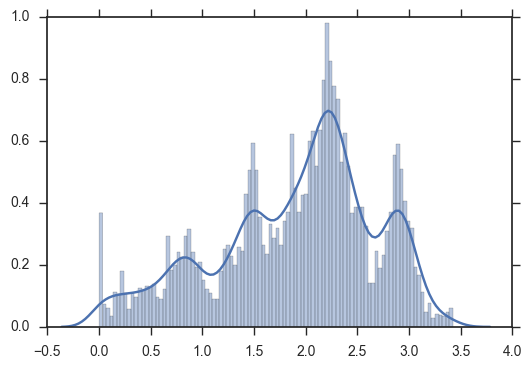

In [26]:
#look at the distribution of distances between leaves
sns.distplot(list(leaf_dist_dict.values()), bins=100)

So there is a sizable peak of distances that are less than 0.1, which we can use as an intial cut off for our v segment clusters. This strategy should largely just reflect the V segment families.

To implement this cutoff, we can do the greedy method of adding any leaf to a cluster if it is under the cutoff distance from any of the leaves already in that cluster. Because of the structure of the data, this probably won't result in too many chained clusters where some members are significantly different than the others.

In [21]:
#make clusters
v_segments = ibd_cln_grtn1.groupby('v')['freq'].sum()
v_segments_sort = v_segments.sort_values(ascending=False)
v_segments_sort = v_segments_sort.drop('TRDV1*01') #remove errant TCRD allele
v_clusters = greedy_cluster(v_segments_sort.index, tree_dist, dist_cutoff=0.1, ete_tree=v_tree)

In [22]:
#get inverse dictionary for cluster assignment
cluster_id_dict = {sub_v: k for k, v in v_clusters.items() for sub_v in v}

In [23]:
#now add a new column in the dataframe giving the cluster assignment
#first drop the mapping to a TCR Delta chain allele
ibd_cln_grtn1_drp_trd = ibd_cln_grtn1.loc[ibd_cln_grtn1['v'] != 'TRDV1*01']
ibd_cln_grtn1_drp_trd['v_clust'] = ibd_cln_grtn1_drp_trd['v'].apply(lambda x: cluster_id_dict[x])
ibd_cln_grtn1_drp_trd_vclust = ibd_cln_grtn1_drp_trd.groupby(['sample', 'v_clust'])['counts', 'freq'].sum()
ibd_cln_grtn1_drp_trd_vclust = ibd_cln_grtn1_drp_trd_vclust.reset_index(level=['sample', 'v_clust'])

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
ibd_cln_grtn1_drp_trd_vclust['v_clust'].nunique()

46

So clustering by phylogentic distance with a cutoff of 0.1 resulted in 46 clusters versus 108 unique v segment alleles as identified previously.

In [26]:
ibd_cln_grtn1_drp_trd_vclust.head()

,sample,v_clust,counts,freq
0,7153B,TRBV10-2*01,239,0.002479
1,7153B,TRBV10-3*01,1032,0.010706
2,7153B,TRBV11-1*01,142,0.001473
3,7153B,TRBV11-2*03,688,0.007137
4,7153B,TRBV11-3*01,14,0.000145


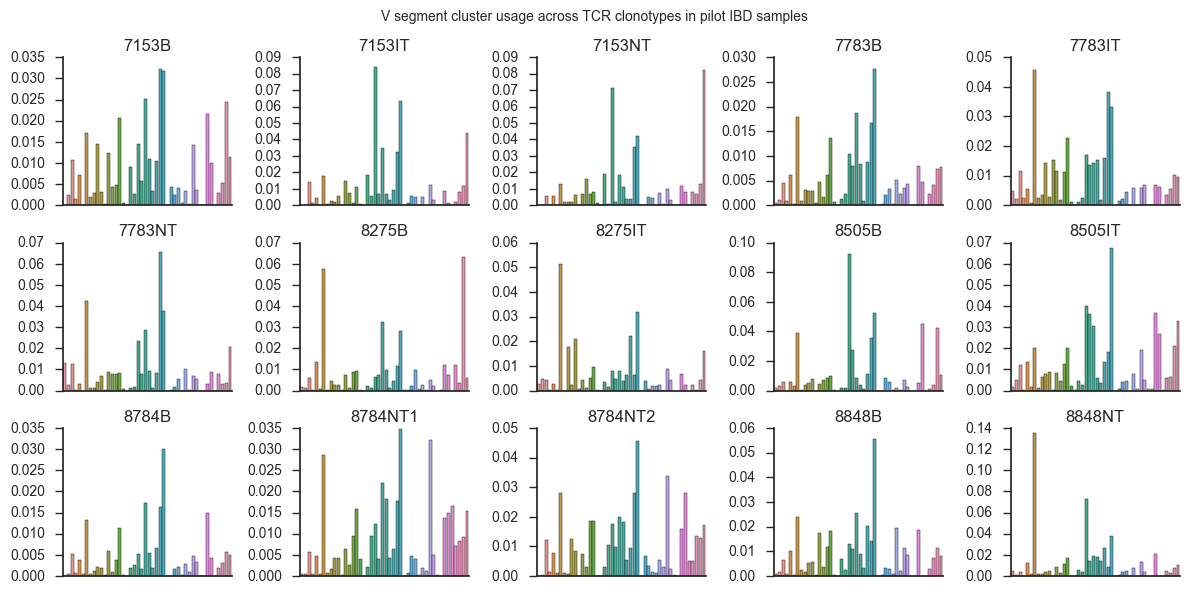

In [77]:
#plot the number of TCRs with any given V cluster for each sample
v_df = pd.DataFrame() #get the same vector of v segment usage for all samples
for name, group in ibd_cln_grtn1_drp_trd_vclust.groupby('sample'):
    group = group.set_index('v_clust')
    v_counts = group['freq'].rename(name)
    v_df = pd.concat([v_df, v_counts], axis=1)
v_df = v_df.fillna(0)

fig = plt.figure(figsize=(12, 6))
plt.suptitle("V segment cluster usage across TCR clonotypes in pilot IBD samples")

counter = 1
for column in v_df:
    ax = fig.add_subplot(3,5,counter)
    sns.barplot(x=v_df.index.values, y=v_df[column].values)
    plt.title(column)
    counter += 1
    ax.xaxis.set_visible(False)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [24]:
#How do these profiles of v clusters look in jaccard similarity?
vclust_jac_htmp = df_pw_heatmap(ibd_cln_grtn1_drp_trd_vclust, 'sample', jaccard_df, 
                             set_column='v_clust').apply(pd.to_numeric)

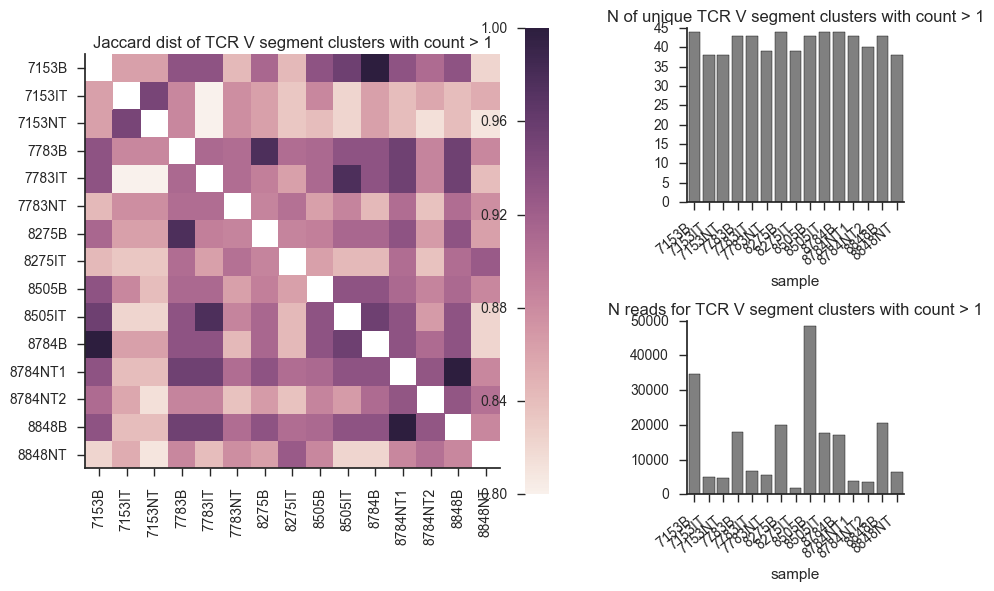

In [92]:
fig = plt.figure(figsize=(10, 6))

#plot heatmap
ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
sns.heatmap(vclust_jac_htmp, square=True, 
            vmin=None, ax=ax1)
ax1.set_title('Jaccard dist of TCR V segment clusters with count > 1')

#plot number of things
ax2 = plt.subplot2grid((2,3), (0,2))
vals = ibd_cln_grtn1_drp_trd_vclust.groupby('sample').apply(lambda x: x['v_clust'].nunique())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax2, color='grey')
ax2.set_xticklabels(x_val, rotation=40, ha='right')
ax2.set_title('N of unique TCR V segment clusters with count > 1')

#plot number of counts
ax3 = plt.subplot2grid((2,3), (1,2))
vals = ibd_cln_grtn1_drp_trd_vclust.groupby('sample').apply(lambda x: x['counts'].sum())
x_val = vals.index
y_val = vals.values
sns.barplot(x_val, y_val, order=x_val, ax=ax3, color='grey')
ax3.set_xticklabels(x_val, rotation=40, ha='right')
ax3.set_title('N reads for TCR V segment clusters with count > 1')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

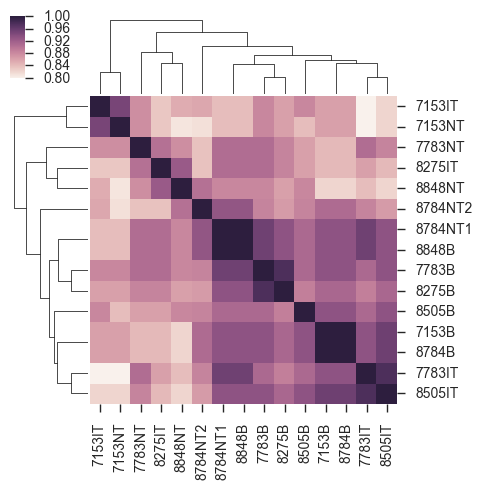

In [32]:
#what if we cluster the output?
cg1 = sns.clustermap(vclust_jac_htmp.fillna(1), figsize=(5, 5))
cg1 = plt.setp(cg1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [34]:
vclust_jsd_htmp = df_pw_heatmap(ibd_cln_grtn1_drp_trd_vclust, 'sample', jsd_df, 
                             set_column_label='v_clust', set_column_freq='freq').apply(pd.to_numeric)

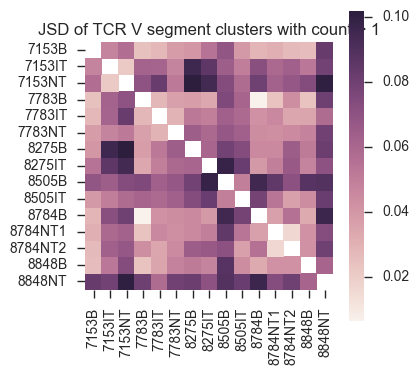

In [106]:
fig = plt.figure(figsize=(4, 4))
ax1 = sns.heatmap(vclust_jsd_htmp, square=True, 
            vmin=None)
ax1.set_title('JSD of TCR V segment clusters with count > 1')

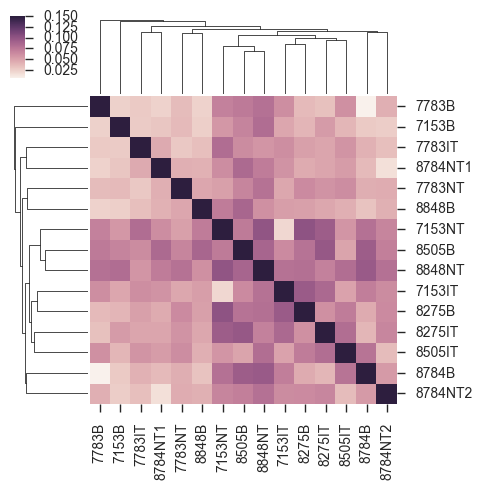

In [36]:
#what if we cluster the output?
cg1 = sns.clustermap(vclust_jsd_htmp.fillna(.15), figsize=(5, 5))
cg1 = plt.setp(cg1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

It is difficult to see any clear pattern here, as individuals, tissue types, and diseases are very much mixed.

In [109]:
vclust_shrjsd_htmp = df_pw_heatmap(ibd_cln_grtn1_drp_trd_vclust, 'sample', shr_jsd_df, 
                             set_column_label='v_clust', set_column_freq='freq').apply(pd.to_numeric)

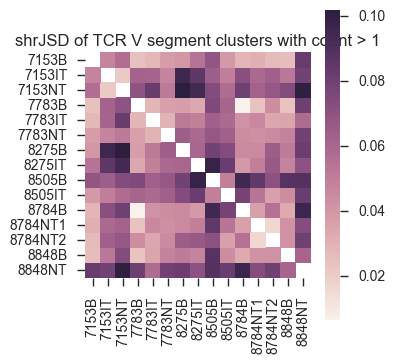

In [37]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(vclust_jsd_htmp, square=True, 
            vmin=None)
ax1.set_title('shrJSD of TCR V segment clusters with count > 1')

So clustering V segments doesn't appear to do much of anything for pattern recognition in TCRs with counts greater than 1. When we cluster the v segments, the overlap between samples is quite high, around 80% in the lowest case. Despite this, the frequency of each v segment cluster doesn't seem to have much individuality. There is some indication that the jaccard distances cluster blood and biopsy samples, although this is not a completely clean break.

The shared JSD is also very similar to the normal JSD in this case because the overlap between samples is already so high. This may not be the same case once we start to incorporate CDR3 sequences.

Let's take a look at doing clustering on the cdr3s, and combining this information with v segment usage.

## Clustering CDR3 regions

In [24]:
#write the cdr3s to a fasta file for hammock clustering
series_to_fasta(ibd_cln_grtn1['cdr3_aa'].dropna().unique(), 
                output_file='/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/cdr3aa_grtn1.fa')

In [5]:
#after hammock clustering, start to explore the clusters made
cdr3_aa_hmmk = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/cdr3_clusters/final_clusters_sequences.tsv',
                          sep='\t')

In [21]:
for name, group in cdr3_aa_hmmk.groupby('cluster_id'):
    out_file = '/Users/ndchu/Documents/tcr_fmt/ibd_tcr_pilot/cdr3_clusters/hmmk_clust' + str(name) + '.fa'
    series_to_fasta(group['alignment'],
                   output_file=out_file)

In [27]:
tmp = cdr3_aa_hmmk.groupby('cluster_id').size()

In [37]:
tmp = ibd_cln_grtn1.loc[ibd_cln_grtn1['cdr3_aa'].str.startswith('AIS', na=False) & ibd_cln_grtn1['cdr3_aa'].str.endswith('GELF', na=False)]

In [45]:
tmp.head()

,cdr3_nt,v,j,prod,sample,counts,patient,tissue,site,disease,cdr3_aa,freq,tcr_epitope,tcr_clonotype
7959,gccatcagctcagggggcgccgacaccggggagctgttt,TRBV10-3*01,TRBJ2-2*01,productive,7153B,1,7153,blood,blood,cd,AISSGGADTGELF,0.000010,tcr_6599,tcr_6659
24038,gccatcagtgaggggacgaacaccggggagctgttt,TRBV10-3*03,TRBJ2-2*01,productive,7153B,1,7153,blood,blood,cd,AISEGTNTGELF,0.000010,tcr_18286,tcr_18484
25071,gccatcagctcagggggcgccgacaccggggagctgttt,TRBV10-3*01,TRBJ2-2*01,productive,7153B,1,7153,blood,blood,cd,AISSGGADTGELF,0.000010,tcr_6599,tcr_6659
36509,gccatcagtgtgggtggaccgggggagctgttt,TRBV10-3*01,TRBJ2-2*01,productive,7153B,2,7153,blood,blood,cd,AISVGGPGELF,0.000021,tcr_26719,tcr_27043
42416,gccatcagtgcgaggggagacaccggggagctgttt,TRBV10-3*01,TRBJ2-2*01,productive,7153B,1,7153,blood,blood,cd,AISARGDTGELF,0.000010,tcr_30551,tcr_30951


In [59]:
tmp['j'].unique()

array(['TRBJ2-2*01'], dtype=object)

In [60]:
tmp1 = ibd_cln_grtn1.loc[ibd_cln_grtn1['j'].isin(['TRBJ2-2*01'])]

In [61]:
tmp2 = tmp1['cdr3_aa'].apply(lambda x: x[-3:])

In [62]:
tmp2.unique()

array(['ELF', 'GLF', 'DLF', 'VLF', 'ELS', 'EPF', 'QLF', 'ALF', 'RLF', 'KLF'], dtype=object)

One aspect that has to be considered is that much of the CDR3 information is actually encoded/included in the v and j segment assignment. There is still a lot of variance in the head and tail of the CDR3 amino acid sequences, but it's an open question how much of a given sequence is already described by the V or J segment, which means that clustering that takes into account these regions (and identifies them as important motifs) are effectively just clustering cdr3s by the v or j segment.

But one should be able to get around this. The most common doublet or triplet is probably the one that's connected to the V and J segments. All of the other ones are probably the actual CDR3 region. Let's examine this.

## Kmer abundances across samples
If we look at the abundance of amino acids or kmers of amino acids, do we see samples that have CDR3s enriched for a given motif or amino acid?

First let's just look at the method over a couple different kmer lengths.

In [23]:
#first look at within a patient, blood versus normal tissue
p7153_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153NT']['cdr3_aa'],
                                 k=1, max_pval=False)
p7153_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153NT']['cdr3_aa'],
                                 k=2, max_pval=False)
p7153_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153NT']['cdr3_aa'],
                                 k=3, max_pval=False)
#sort by abs: df = df.reindex(df['col'].abs().sort_values(ascending=False).index)

total kmers in the first iterable is 232509
total kmers in the second iterable is 27752
total kmers in the first iterable is 298068
total kmers in the second iterable is 36092
total kmers in the first iterable is 277968
total kmers in the second iterable is 33332


In [24]:
#Look at a similar patient, do we see any hint of overlap?
p7783_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783NT']['cdr3_aa'],
                                 k=1, max_pval=False)
p7783_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783NT']['cdr3_aa'],
                                 k=2, max_pval=False)
p7783_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783NT']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 135721
total kmers in the second iterable is 34906
total kmers in the first iterable is 173983
total kmers in the second iterable is 46065
total kmers in the first iterable is 162663
total kmers in the second iterable is 43087


In [25]:
#Look at a acress patient blood samples, are the differences starker?
p7153b_p7783b_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 k=1, max_pval=False)
p7153b_p7783b_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 k=2, max_pval=False)
p7153b_p7783b_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7153B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '7783B']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 232509
total kmers in the second iterable is 135721
total kmers in the first iterable is 298068
total kmers in the second iterable is 173983
total kmers in the first iterable is 277968
total kmers in the second iterable is 162663


So these signatures at visual inspection look pretty individual-specific. We should probably do multiple hypothesis correction on the p values, since as it is over 50% of possible combinations (in the case of kmers of length 2) are being tagged as significant. Changed in the function to add this column.

Would plotting the distribution of p values for different comparisons be useful? It would indicate which samples are less similar, as the distribution between those samples would be more shifted towards significant values

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


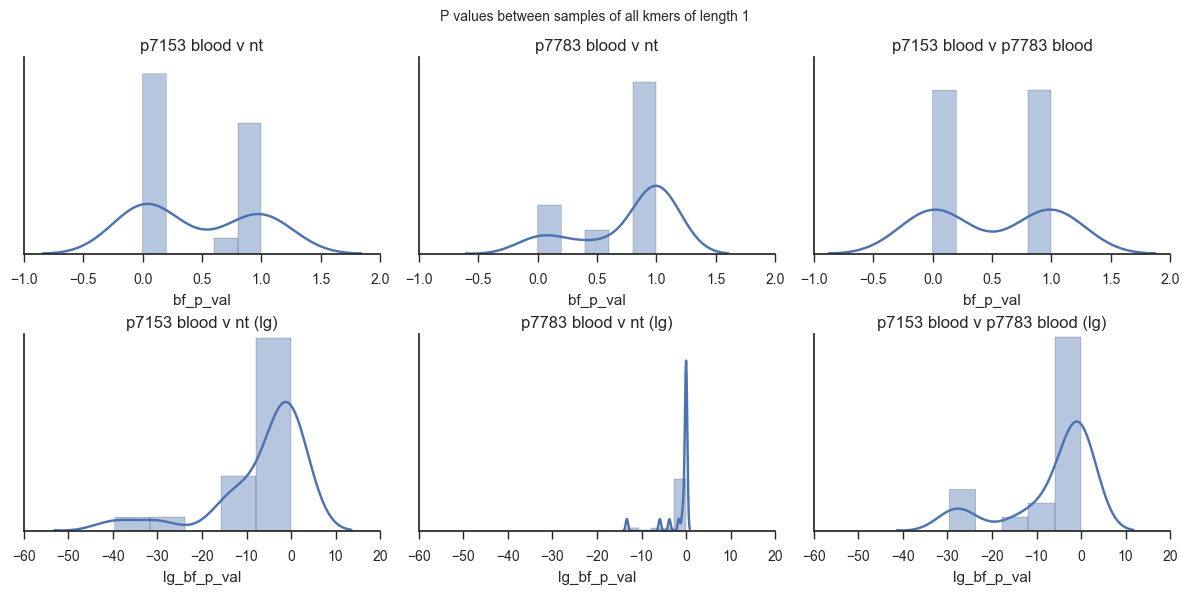

In [54]:
#Examine the distribution of p vals between samples
fig = plt.figure(figsize=(12, 6))
plt.suptitle("P values between samples of all kmers of length 1")

ax1 = fig.add_subplot(2,3,1)
sns.distplot(p7153_aa1['bf_p_val'], bins=5)
ax1.yaxis.set_visible(False)
plt.title('p7153 blood v nt')

ax2 = fig.add_subplot(2,3,2, sharex=ax1)
sns.distplot(p7783_aa1['bf_p_val'], bins=5)
ax2.yaxis.set_visible(False)
plt.title('p7783 blood v nt')

ax3 = fig.add_subplot(2,3,3, sharex=ax1)
sns.distplot(p7153b_p7783b_aa1['bf_p_val'], bins=5)
ax3.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood')

ax4 = fig.add_subplot(2,3,4)
sns.distplot(p7153_aa1['lg_bf_p_val'], bins=5)
ax4.yaxis.set_visible(False)
plt.title('p7153 blood v nt (lg)')

ax5 = fig.add_subplot(2,3,5, sharex=ax4)
sns.distplot(p7783_aa1['lg_bf_p_val'], bins=5)
ax5.yaxis.set_visible(False)
plt.title('p7783 blood v nt (lg)')

ax6 = fig.add_subplot(2,3,6, sharex=ax4)
sns.distplot(p7153b_p7783b_aa1['lg_bf_p_val'], bins=5)
ax6.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood (lg)')

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


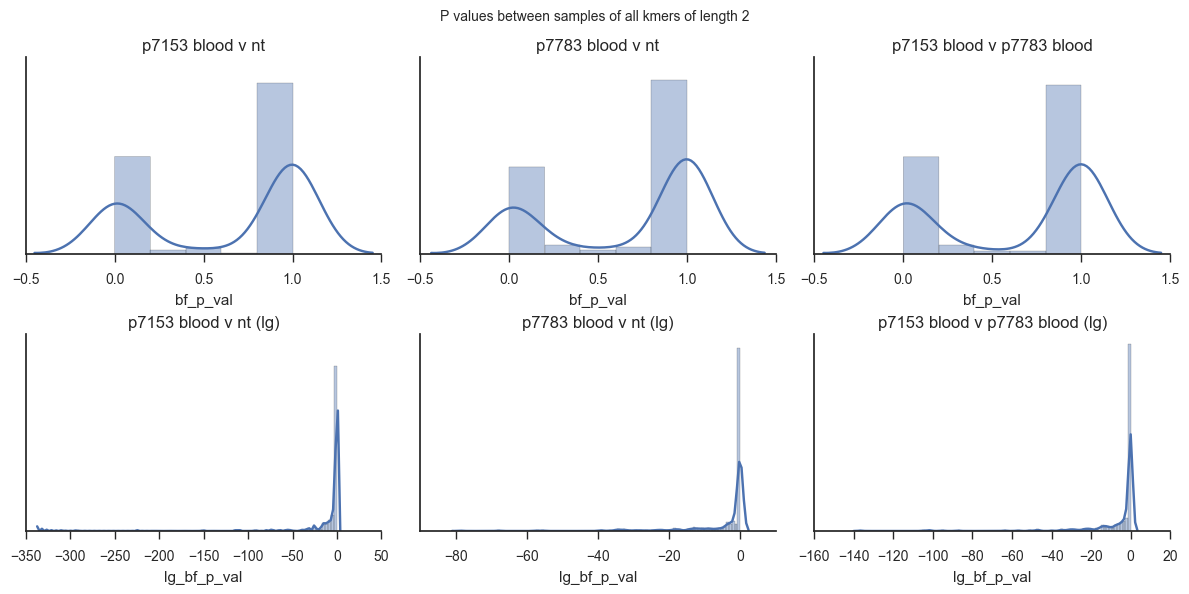

In [64]:
#Examine the distribution of p vals between samples
fig = plt.figure(figsize=(12, 6))
plt.suptitle("P values between samples of all kmers of length 2")

ax1 = fig.add_subplot(2,3,1)
sns.distplot(p7153_aa2['bf_p_val'], bins=5)
ax1.yaxis.set_visible(False)
plt.title('p7153 blood v nt')

ax2 = fig.add_subplot(2,3,2, sharex=ax1)
sns.distplot(p7783_aa2['bf_p_val'], bins=5)
ax2.yaxis.set_visible(False)
plt.title('p7783 blood v nt')

ax3 = fig.add_subplot(2,3,3, sharex=ax1)
sns.distplot(p7153b_p7783b_aa2['bf_p_val'], bins=5)
ax3.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood')

ax4 = fig.add_subplot(2,3,4)
sns.distplot(p7153_aa2['lg_bf_p_val'], bins=100)
ax4.yaxis.set_visible(False)
plt.title('p7153 blood v nt (lg)')

ax5 = fig.add_subplot(2,3,5)
sns.distplot(p7783_aa2['lg_bf_p_val'], bins=100)
ax5.yaxis.set_visible(False)
plt.title('p7783 blood v nt (lg)')

ax6 = fig.add_subplot(2,3,6)
sns.distplot(p7153b_p7783b_aa2['lg_bf_p_val'], bins=100)
ax6.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood (lg)')

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


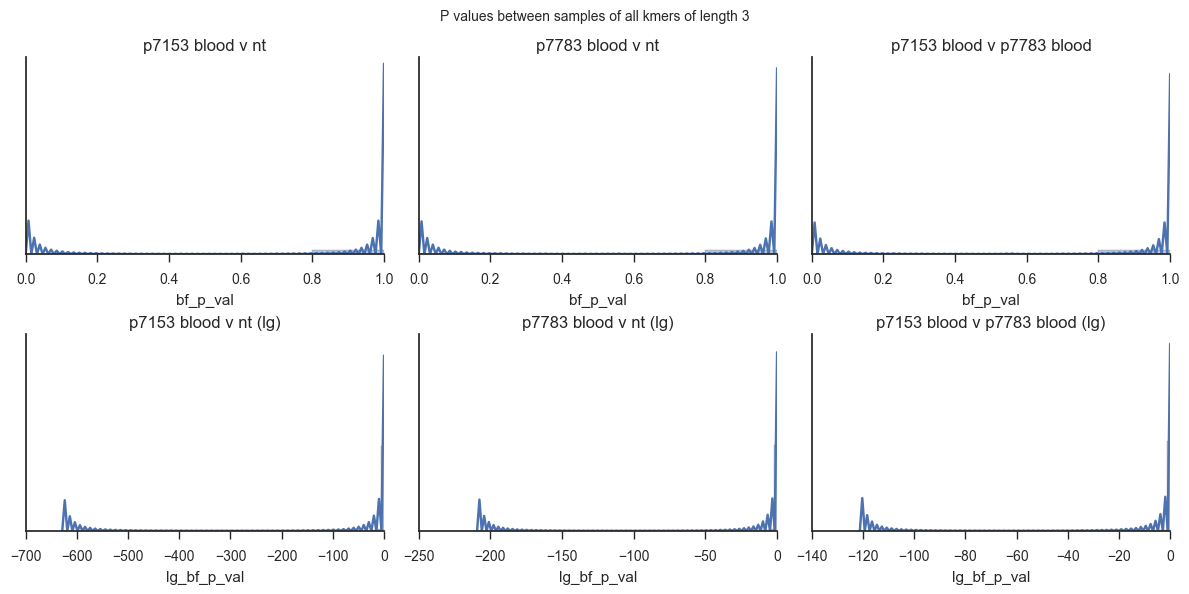

In [65]:
#Examine the distribution of p vals between samples
fig = plt.figure(figsize=(12, 6))
plt.suptitle("P values between samples of all kmers of length 3")

ax1 = fig.add_subplot(2,3,1)
sns.distplot(p7153_aa3['bf_p_val'], bins=5)
ax1.yaxis.set_visible(False)
plt.title('p7153 blood v nt')

ax2 = fig.add_subplot(2,3,2, sharex=ax1)
sns.distplot(p7783_aa3['bf_p_val'], bins=5)
ax2.yaxis.set_visible(False)
plt.title('p7783 blood v nt')

ax3 = fig.add_subplot(2,3,3, sharex=ax1)
sns.distplot(p7153b_p7783b_aa3['bf_p_val'], bins=5)
ax3.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood')

ax4 = fig.add_subplot(2,3,4)
sns.distplot(p7153_aa3['lg_bf_p_val'], bins=100)
ax4.yaxis.set_visible(False)
plt.title('p7153 blood v nt (lg)')

ax5 = fig.add_subplot(2,3,5)
sns.distplot(p7783_aa3['lg_bf_p_val'], bins=100)
ax5.yaxis.set_visible(False)
plt.title('p7783 blood v nt (lg)')

ax6 = fig.add_subplot(2,3,6)
sns.distplot(p7153b_p7783b_aa3['lg_bf_p_val'], bins=100)
ax6.yaxis.set_visible(False)
plt.title('p7153 blood v p7783 blood (lg)')

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So over all, we can see that the great majority of kmers are clustered around being not significant, with a few being very significant. The results using a single amino acids seem to have a reliably bimodal distribution across multiple lengths of kmer (1-3). The log of these p values is perhaps more informative, although neither of these metrics really captures well between individual versus within individual differences. 

One outstanding question is whether these highly significant kmers are representative of a since TCR clonotype or epitope, or if they are actually occuring over multiple TCRs, which would make it more convincing that the kmers are "enriched" in those samples.

Another observation is that in cases looking at significant kmers between tissues from the same individual, the 2 and 3 kmer lengths mirror each other to a great deal for the most significant kmers. In other words, the top 3-mers might be ADQ, QAN, and VAD, while the top 2-mers are DQ, QA, and VA, as is the case for comparisons between blood and healthy biopsy tissue in patient 7153. Between individuals, this pattern is not as evident, perhaps because of the much smaller overlap in TCR clonotypes.

Remaining questions:
1. Do we see any signs of convergence of V segments or kmers across tissue types/antigen exposure?
2. Do we see certain kmers being over expressed with certain V or J segment combinations?
3. If we take frequency of the TCR into account, how does that reflect in the overall abundance of different kmer/VJ segment combinations?

In [26]:
#Let's look at differences between blood and biopsy, NT if available (CD)
p8275_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275IT']['cdr3_aa'],
                                 k=1, max_pval=False)
p8275_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275IT']['cdr3_aa'],
                                 k=2, max_pval=False)
p8275_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8275IT']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 107987
total kmers in the second iterable is 12830
total kmers in the first iterable is 140798
total kmers in the second iterable is 16075
total kmers in the first iterable is 130900
total kmers in the second iterable is 15081


In [27]:
p8505_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505IT']['cdr3_aa'],
                                 k=1, max_pval=False)
p8505_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505IT']['cdr3_aa'],
                                 k=2, max_pval=False)
p8505_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8505IT']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 229049
total kmers in the second iterable is 120807
total kmers in the first iterable is 295853
total kmers in the second iterable is 153160
total kmers in the first iterable is 276316
total kmers in the second iterable is 142574


In [28]:
p8784_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784NT1']['cdr3_aa'],
                                 k=1, max_pval=False)
p8784_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784NT1']['cdr3_aa'],
                                 k=2, max_pval=False)
p8784_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8784NT1']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 133996
total kmers in the second iterable is 27620
total kmers in the first iterable is 171727
total kmers in the second iterable is 35525
total kmers in the first iterable is 160060
total kmers in the second iterable is 33121


In [29]:
p8848_aa1 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848NT']['cdr3_aa'],
                                 k=1, max_pval=False)
p8848_aa2 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848NT']['cdr3_aa'],
                                 k=2, max_pval=False)
p8848_aa3 = differential_kmers(ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848B']['cdr3_aa'],
                                 ibd_cln_grtn1.loc[ibd_cln_grtn1['sample'] == '8848NT']['cdr3_aa'],
                                 k=3, max_pval=False)

total kmers in the first iterable is 144803
total kmers in the second iterable is 35727
total kmers in the first iterable is 187525
total kmers in the second iterable is 46494
total kmers in the first iterable is 174848
total kmers in the second iterable is 43173


In [174]:
#plot a heatmap of these results for aa1
tmp_tabs = [p7153_aa1, p7783_aa1, p8275_aa1, p8505_aa1, p8784_aa1, p8848_aa1]
tmp_names = ['p7153', 'p7783', 'p8275', 'p8505', 'p8784', 'p8848']
kmer_htmp1 = pd.DataFrame(index=p7153_aa1['kmer_seq'])
for ix, tab in enumerate(tmp_tabs):
    tmp = tab[['kmer_seq', 'lg_chg']].set_index('kmer_seq', drop=True)
    tmp = tmp.rename(columns={'lg_chg': tmp_names[ix]})
    kmer_htmp1 = pd.concat([kmer_htmp1, tmp], axis=1)

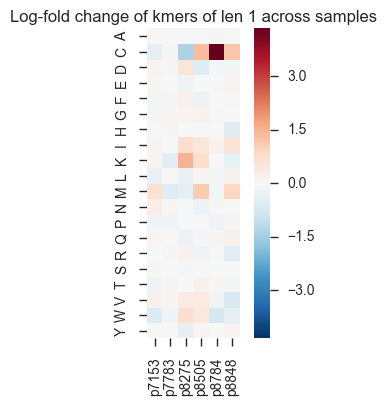

In [163]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(kmer_htmp1, square=True, 
            vmin=None)
ax1.set_title('Log-fold change of kmers of len 1 across samples')

So for single amino acids (kmer len = 1), there doesn't appear to be any amino acids that are reliably up or down in biopsy vesus blood samples across individuals.

When we amplify to looking at kmers of length 2, we have a problem of scale (400 kmers, and ~350 are present in all patients). If we only look at things that are significant in at least 2 patients, that get us down to 208. If we only look at kmers signficant in 2 patients that have an abs(log fold change) > 1, then we get down to 166. For kmers signficant in at least 3 patients, we're down to 111. And for abs 1 and 3 patients, 85.

In [69]:
#plot a heatmap of these results for aa2. Plot kmers that are significant in at least two
#samples
tmp_tabs = [p7153_aa2, p7783_aa2, p8275_aa2, p8505_aa2, p8784_aa2, p8848_aa2]
tmp_names = ['p7153', 'p7783', 'p8275', 'p8505', 'p8784', 'p8848']

#get kmers significant in at least 2 patients
tmp_tabs_kmers = [x.loc[x['bf_p_val'] < 0.05]['kmer_seq'] for x in tmp_tabs]
sig_cts_kmer2 = defaultdict(int)
for tab in tmp_tabs_kmers:
    for kmer in tab:
        sig_cts_kmer2[kmer] += 1
kmer2_sam2 = [kmer for kmer, count in sig_cts_kmer2.items() if count > 1] #list of passing kmers

#get kmers significant in at least 3 patients
tmp_tabs_kmers = [x.loc[x['bf_p_val'] < 0.05]['kmer_seq'] for x in tmp_tabs]
sig_cts_kmer3 = defaultdict(int)
for tab in tmp_tabs_kmers:
    for kmer in tab:
        sig_cts_kmer3[kmer] += 1
kmer2_sam3 = [kmer for kmer, count in sig_cts_kmer3.items() if count > 2] #list of passing kmers

#get kmers significant in at least 2 patients and log fold change of at least abs(x) > 1
tmp_tabs_kmers = [x.loc[x['kmer_seq'].isin(kmer2_sam2)] for x in tmp_tabs]
                    #tables incorporate previous filter
tmp_tabs_kmers = [x.loc[x['lg_chg'].abs() > 1] for x in tmp_tabs_kmers]
kmer2_abs1 = pd.Series() #list of passing kmers
for tab in tmp_tabs_kmers:
    kmer2_abs1 = kmer2_abs1.append(tab['kmer_seq'])
kmer2_abs1 = kmer2_abs1.unique()

#get kmers significant in at least 2 patients and log fold change of at least abs(x) > 1
tmp_tabs_kmers = [x.loc[x['kmer_seq'].isin(kmer2_sam3)] for x in tmp_tabs]
                    #tables incorporate previous filter
tmp_tabs_kmers = [x.loc[x['lg_chg'].abs() > 1] for x in tmp_tabs_kmers]
kmer3_abs1 = pd.Series() #list of passing kmers
for tab in tmp_tabs_kmers:
    kmer3_abs1 = kmer3_abs1.append(tab['kmer_seq'])
kmer3_abs1 = kmer3_abs1.unique()

kmer_htmp2 = pd.DataFrame(index=p7153_aa2['kmer_seq'])
for ix, tab in enumerate(tmp_tabs):
    tab = tab.loc[tab['kmer_seq'].isin(kmer3_abs1)]
    tmp = tab[['kmer_seq', 'lg_chg']].set_index('kmer_seq', drop=True)
    tmp = tmp.rename(columns={'lg_chg': tmp_names[ix]})
    kmer_htmp2 = pd.concat([kmer_htmp2, tmp], axis=1)
kmer_htmp2 = kmer_htmp2.dropna(axis=0, how='all')

In [ ]:
#replace infinite values

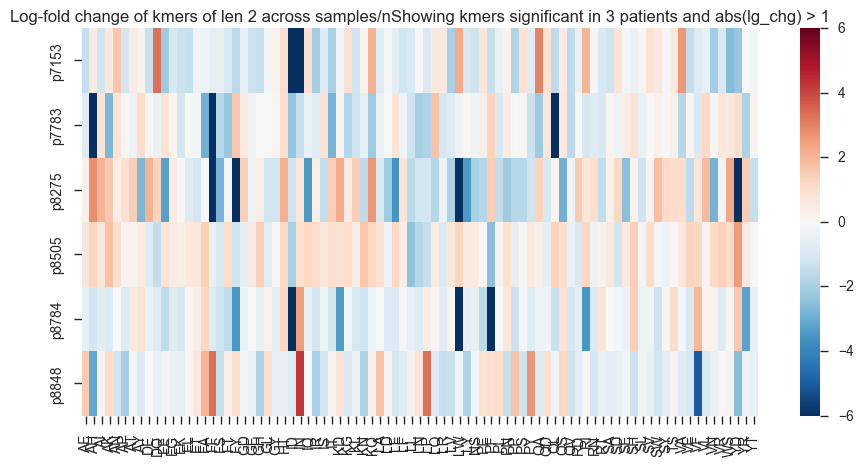

In [81]:
fig = plt.figure(figsize=(24, 5))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(kmer_htmp2.T, vmin=-6, vmax=6)
ax1.set_title('Log-fold change of kmers of len 2 across samples: Showing kmers significant in 3 patients and abs(lg_chg) > 1')

In [101]:
kmer_htmp2.T

,AE,AH,AI,AK,AN,AP,AT,AY,DE,DQ,...,VA,VE,VF,VL,VN,VR,WS,YD,YR,YT
p7153,-1.425785,0.476035,-1.203618,0.606779,1.658539,-1.083393,0.489273,0.231902,-1.357122,3.316248,...,2.650429,-1.495071,-0.761464,-0.495206,-2.083393,-0.861000,-2.578600,-2.325668,0.028543,-0.152675
p7783,-0.740774,-inf,0.814842,-2.693294,0.825174,0.104705,-0.355517,1.096033,0.073074,-0.383192,...,-1.687659,0.104662,-0.890151,1.255038,0.050828,0.721539,0.607875,0.987593,-1.882772,0.181590
p8275,0.323381,2.777099,2.039828,1.600221,0.428280,0.922843,1.482543,-2.697083,2.073403,1.397675,...,1.103936,-1.580759,0.697777,1.908344,-2.838890,-0.204248,2.342240,-inf,1.531274,-1.450213
p8505,0.695268,1.326404,0.678314,1.746854,1.003446,0.186378,0.206131,0.560213,-0.736050,-1.473701,...,0.627913,1.394936,1.297764,0.155964,1.174908,1.414392,1.126719,2.534803,0.514904,-0.054008
p8784,-0.477855,-1.119107,-0.688316,-0.840532,-0.028757,-0.840352,0.563430,0.889882,-0.428885,-0.769282,...,-0.115060,-0.934683,1.975530,0.229583,0.231390,-0.772304,0.042256,1.626847,-3.207916,-0.459257
p8848,1.561021,-3.137781,0.048992,1.146896,-1.214948,-2.041145,-0.200131,-0.755587,-0.017298,-0.500846,...,-0.730701,-0.984751,-5.032428,-0.982387,-0.467503,0.046182,0.252975,-2.532354,-0.354816,-0.548985


ValueError: The condensed distance matrix must contain only finite values.

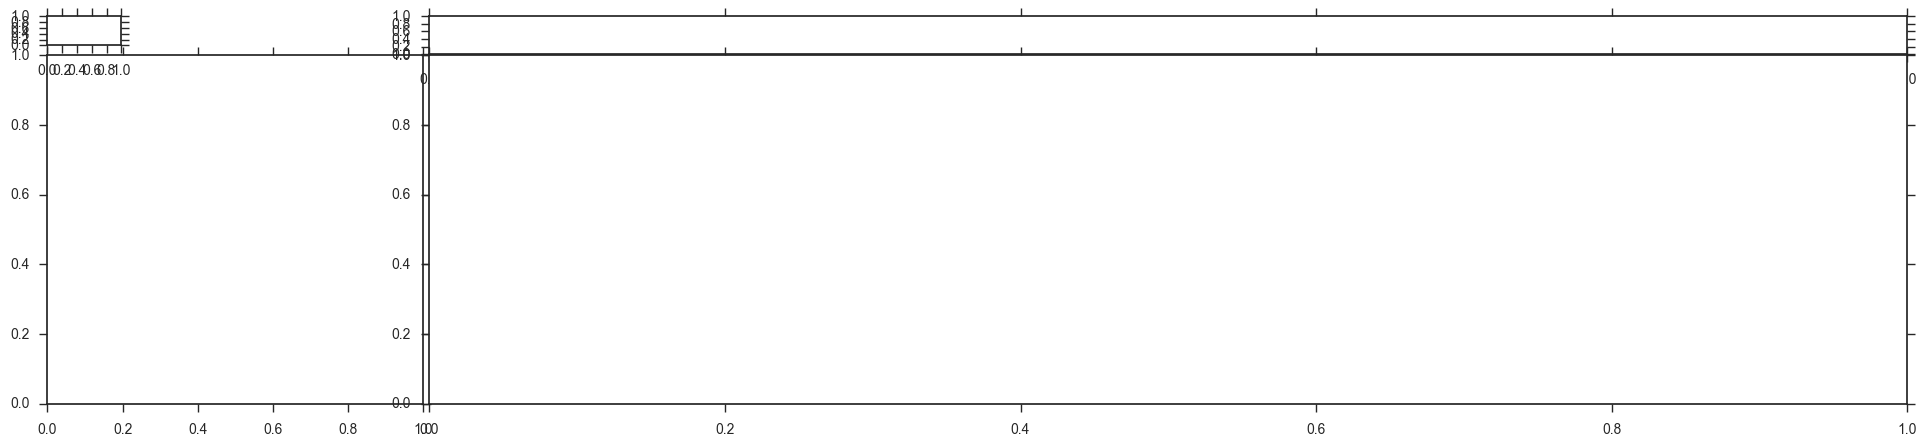

In [83]:
df.replace([np.inf, -np.inf], np.nan)
cg1 = sns.clustermap(kmer_htmp2.T.fillna(0), figsize=(24, 5))
cg1 = plt.setp(cg1.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [90]:
tmp = p7153_aa2.loc[(p7153_aa2['count_1'] == 0) | (p7153_aa2['count_2'] == 0)]

In [98]:
p7153_aa2.head()

,kmer_seq,count_1,count_2,freq_1,freq_2,lg_chg,fe_odds,p_val,bf_p_val,lg_bf_p_val
95,DQ,262.0,316.0,0.000879,0.008755,3.316248,0.099603,3.976359e-148,1.511016e-145,-333.462056
350,QA,357.0,337.0,0.001198,0.009337,2.962715,0.127227,2.631446e-137,9.999497e-135,-308.546453
82,VA,488.0,371.0,0.001637,0.010279,2.650429,0.157894,1.961655e-130,7.454289e-128,-292.722102
318,AD,610.0,356.0,0.002047,0.009864,2.268959,0.205854,7.052684e-101,2.680020e-98,-224.667515
74,AN,1015.0,388.0,0.003405,0.010750,1.658539,0.314425,1.143320e-68,4.344615e-66,-150.501679


In [99]:
((p7153_aa2['count_1'] == 0) | (p7153_aa2['count_2'] == 0)).sum()

57

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


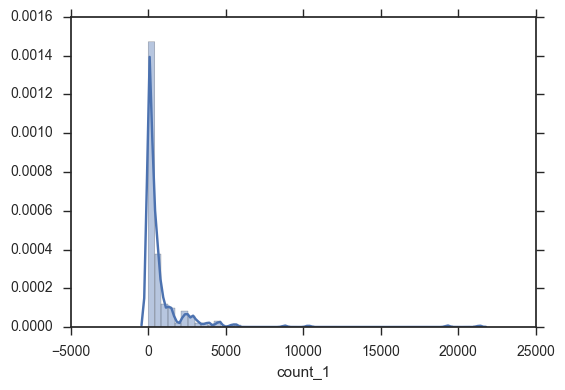

In [100]:
sns.distplot(p7153_aa2['count_1'])